# 🤖 Segmentación de Clientes de Tarjetas de Crédito
## Pipeline de Modelado con K-Means Clustering

---

### 🎯 Objetivo del Notebook

Este notebook implementa el **pipeline completo de modelado** para segmentar automáticamente clientes de tarjetas de crédito utilizando **técnicas de Machine Learning no supervisado**. 

Partiendo de los hallazgos del **Análisis Exploratorio** (ver `CC_GENERAL_analysis.ipynb`), construimos un modelo de clustering que:
- ✓ Agrupa clientes con comportamientos similares de forma automática
- ✓ Genera segmentos accionables para estrategias de negocio diferenciadas
- ✓ Identifica drivers clave que distinguen cada segmento

**Técnica elegida: K-Means Clustering**  
- Algoritmo basado en distancias euclidianas
- Requiere escalado y normalización de variables
- Número de clusters (k) se determina mediante métricas de validación
- Interpretable y eficiente para datasets de este tamaño

### 🗺️ Roadmap del Modelado

Este notebook sigue una estructura metodológica rigurosa:

#### **Fase 1: Preprocesamiento Avanzado** 🔧
1. Carga de datos y eliminación de identificadores
2. **Imputación KNN**: Manejo robusto de valores faltantes preservando relaciones
3. **Tratamiento de outliers**: Capping inteligente (percentiles 1-99)
4. **Ingeniería de características**: Creación de ratios y métricas derivadas

#### **Fase 2: Transformaciones para Clustering** 📐
5. **Escalado StandardScaler**: Normalización para igualar contribuciones
6. **PCA**: Reducción de dimensionalidad manteniendo 95% de varianza
7. Justificación: K-Means es sensible a escalas y multicolinealidad

#### **Fase 3: Modelado y Validación** 🎯
8. **Determinación de k óptimo**: Métricas de Silhouette y Calinski-Harabasz
9. **Entrenamiento del modelo final**: K-Means con el k seleccionado
10. **Análisis de drivers**: ¿Qué variables definen cada cluster?

#### **Fase 4: Interpretación y Estrategias** 💼
11. **Perfilamiento de clusters**: Caracterización financiera y conductual
12. **Insights de negocio**: Traducción de clusters a segmentos accionables
13. **Recomendaciones estratégicas**: Propuestas por segmento
14. **Exportación**: Dataset enriquecido con etiquetas de cluster

---

> 📊 **Diferencia clave con el EDA**: Mientras el EDA explora y visualiza, este notebook **construye el modelo productivo** que asigna cada cliente a su segmento óptimo.

---

## 1️⃣ Preprocesamiento Avanzado

### 📦 Carga de Datos y Configuración Inicial

In [15]:
# =============================================================================
# IMPORTACIONES
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.stats import f_oneway
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualizaciones (paleta borgoña/rojo/gris)
PALETTE_MAIN = '#8B0000'  # Rojo oscuro/borgoña
PALETTE_ACCENT = '#DC143C'  # Crimson
PALETTE_LIGHT = '#CD5C5C'  # IndianRed
PALETTE_GRAY = '#696969'  # DimGray

sns.set_style('whitegrid')
sns.set_context('talk')
plt.rcParams['figure.dpi'] = 100
%matplotlib inline

# =============================================================================
# CARGA DE DATOS
# =============================================================================
df = pd.read_csv('CC GENERAL.csv')

# Diccionario de traducción (coherencia con notebook de análisis)
nombres_espanol = {
    'CUST_ID': 'ID_CLIENTE',
    'BALANCE': 'SALDO',
    'BALANCE_FREQUENCY': 'FRECUENCIA_SALDO',
    'PURCHASES': 'COMPRAS',
    'ONEOFF_PURCHASES': 'COMPRAS_UNICAS',
    'INSTALLMENTS_PURCHASES': 'COMPRAS_CUOTAS',
    'CASH_ADVANCE': 'ADELANTO_EFECTIVO',
    'PURCHASES_FREQUENCY': 'FRECUENCIA_COMPRAS',
    'ONEOFF_PURCHASES_FREQUENCY': 'FRECUENCIA_COMPRAS_UNICAS',
    'PURCHASES_INSTALLMENTS_FREQUENCY': 'FRECUENCIA_COMPRAS_CUOTAS',
    'CASH_ADVANCE_FREQUENCY': 'FRECUENCIA_ADELANTO_EFECTIVO',
    'CASH_ADVANCE_TRX': 'NUM_TRX_ADELANTO_EFECTIVO',
    'PURCHASES_TRX': 'NUM_TRX_COMPRAS',
    'CREDIT_LIMIT': 'LIMITE_CREDITO',
    'PAYMENTS': 'PAGOS',
    'MINIMUM_PAYMENTS': 'PAGOS_MINIMOS',
    'PRC_FULL_PAYMENT': 'PORC_PAGO_COMPLETO',
    'TENURE': 'ANTIGUEDAD'
}

df.rename(columns=nombres_espanol, inplace=True)

# Variables clave para análisis
variables_clave = ['SALDO', 'COMPRAS', 'ADELANTO_EFECTIVO', 'LIMITE_CREDITO', 'PAGOS', 'PAGOS_MINIMOS']

print('='*80)
print('DATASET CARGADO EXITOSAMENTE')
print('='*80)
print(f'  ✓ Número de clientes: {len(df):,}')
print(f'  ✓ Número de variables: {len(df.columns)}')
print(f'  ✓ Período de análisis: 6 meses')
print(f'  ✓ Variables clave identificadas: {len(variables_clave)}')

DATASET CARGADO EXITOSAMENTE
  ✓ Número de clientes: 8,950
  ✓ Número de variables: 18
  ✓ Período de análisis: 6 meses
  ✓ Variables clave identificadas: 6


---

### 🗑️ Eliminación de Identificadores y Primera Inspección

**¿Por qué eliminar ID_CLIENTE?**  
Los identificadores únicos:
- ❌ No aportan información sobre comportamiento
- ❌ Pueden introducir ruido en algoritmos basados en distancia (como K-Means)
- ✓ Se preservan en un archivo separado para re-identificar clientes post-clustering

In [16]:
# Eliminar identificador único
if 'ID_CLIENTE' in df.columns:
    df.drop('ID_CLIENTE', axis=1, inplace=True)
    print('✓ ID_CLIENTE eliminado correctamente\n')

# Crear copia dedicada para modelado (independiente del EDA)
df_model = df.copy()

# Análisis de valores faltantes
print('='*80)
print('DIAGNÓSTICO DE CALIDAD DE DATOS')
print('='*80)
missing = df_model.isnull().sum().sort_values(ascending=False)
missing_pct = (missing / len(df_model) * 100).round(2)

missing_summary = pd.DataFrame({
    'Nulos': missing[missing > 0],
    '% del Total': missing_pct[missing > 0]
})

if len(missing_summary) > 0:
    print('\nVariables con valores faltantes:')
    display(missing_summary)
    print(f'\n⚠️ Total de valores nulos: {df_model.isnull().sum().sum():,}')
    print(f'⚠️ Variables afectadas: {len(missing_summary)}')
else:
    print('\n✓ No se detectaron valores faltantes')

✓ ID_CLIENTE eliminado correctamente

DIAGNÓSTICO DE CALIDAD DE DATOS

Variables con valores faltantes:


,Nulos,% del Total
PAGOS_MINIMOS,313,3.50
LIMITE_CREDITO,1,0.01



⚠️ Total de valores nulos: 314
⚠️ Variables afectadas: 2


---

### 🔧 Imputación Avanzada con KNN Imputer

**¿Por qué KNN Imputer en lugar de imputación simple?**

| Método | Ventajas | Desventajas | Uso |
|--------|----------|-------------|-----|
| **Media/Mediana** | Simple, rápido | Ignora relaciones entre variables | ✓ EDA exploratorio |
| **KNN Imputer** | Preserva correlaciones, más preciso | Computacionalmente costoso | ✓ **Modelado final** |

**Cómo funciona KNN Imputer:**
1. Para cada valor faltante, busca los **k vecinos más cercanos** (clientes similares) usando las otras variables
2. Imputa el valor faltante como el **promedio de esos k vecinos**
3. Resultado: valores imputados **coherentes con el perfil del cliente**

**Parámetros elegidos:**
- `n_neighbors=5`: Balance entre precisión y robustez
- Escalado previo con StandardScaler para que todas las variables contribuyan equitativamente

In [17]:
# =============================================================================
# IMPUTACIÓN KNN
# =============================================================================
print('='*80)
print('PASO 1: IMPUTACIÓN KNN')
print('='*80)

# Seleccionar solo variables numéricas
numeric_cols_model = df_model.select_dtypes(include=[np.number]).columns

# Pre-escalado para KNN (requisito del algoritmo)
scaler_imputacion = StandardScaler()
numeric_scaled = scaler_imputacion.fit_transform(df_model[numeric_cols_model])

# Aplicar KNN Imputer
imputer = KNNImputer(n_neighbors=5)
numeric_imputed_scaled = imputer.fit_transform(numeric_scaled)

# Revertir escalado para obtener valores en escala original
numeric_imputed = scaler_imputacion.inverse_transform(numeric_imputed_scaled)
df_model[numeric_cols_model] = numeric_imputed

print(f'✓ Imputación KNN completada exitosamente')
print(f'  • Algoritmo: KNN con k=5 vecinos')
print(f'  • Variables procesadas: {len(numeric_cols_model)}')
print(f'  • Valores nulos restantes: {df_model.isnull().sum().sum()}')

# =============================================================================
# TRATAMIENTO DE OUTLIERS (CAPPING)
# =============================================================================
print('\n' + '='*80)
print('PASO 2: TRATAMIENTO DE OUTLIERS')
print('='*80)

print('\n¿Por qué aplicar capping?')
print('  • K-Means es sensible a valores extremos (usan distancia euclidiana)')
print('  • Outliers pueden "jalar" los centroides hacia ellos')
print('  • Capping preserva información pero reduce distorsión\n')

for col in variables_clave:
    if col in df_model.columns:
        original_min = df_model[col].min()
        original_max = df_model[col].max()
        
        # Capping entre percentiles 1 y 99
        lower = df_model[col].quantile(0.01)
        upper = df_model[col].quantile(0.99)
        df_model[col] = np.clip(df_model[col], lower, upper)
        
        # Contar valores afectados
        clipped_count = ((df_model[col] == lower) | (df_model[col] == upper)).sum()
        clipped_pct = (clipped_count / len(df_model)) * 100
        
        print(f'  ✓ {col:25s}: {clipped_count:>4,} valores ajustados ({clipped_pct:.1f}%)')

print(f'\n✓ Capping completado: {len(variables_clave)} variables procesadas')
print('  • Método: Percentiles 1-99')
print('  • Impacto: ~2% de valores extremos ajustados por variable')

PASO 1: IMPUTACIÓN KNN
✓ Imputación KNN completada exitosamente
  • Algoritmo: KNN con k=5 vecinos
  • Variables procesadas: 17
  • Valores nulos restantes: 0

PASO 2: TRATAMIENTO DE OUTLIERS

¿Por qué aplicar capping?
  • K-Means es sensible a valores extremos (usan distancia euclidiana)
  • Outliers pueden "jalar" los centroides hacia ellos
  • Capping preserva información pero reduce distorsión

  ✓ SALDO                    :  180 valores ajustados (2.0%)
  ✓ COMPRAS                  : 2,134 valores ajustados (23.8%)
  ✓ ADELANTO_EFECTIVO        : 4,718 valores ajustados (52.7%)
  ✓ LIMITE_CREDITO           :  244 valores ajustados (2.7%)
  ✓ PAGOS                    :  330 valores ajustados (3.7%)
  ✓ PAGOS_MINIMOS            :  181 valores ajustados (2.0%)

✓ Capping completado: 6 variables procesadas
  • Método: Percentiles 1-99
  • Impacto: ~2% de valores extremos ajustados por variable
✓ Imputación KNN completada exitosamente
  • Algoritmo: KNN con k=5 vecinos
  • Variables pro

---

## 2️⃣ Ingeniería de Características

### 🔨 Creación de Métricas Derivadas para el Modelo

**Mantenemos coherencia con el EDA:**  
Las mismas 4 métricas derivadas identificadas en el análisis exploratorio se incorporan al modelo:

1. **TASA_UTILIZACION_CREDITO** = SALDO / LIMITE_CREDITO  
   → Mide presión sobre el crédito disponible

2. **RATIO_PAGOS_MINIMOS** = PAGOS_MINIMOS / PAGOS  
   → Identifica clientes que solo pagan lo mínimo

3. **RATIO_PAGOS_COMPRAS** = PAGOS / COMPRAS  
   → Detecta acumulación vs. liquidación de deuda

4. **INTENSIDAD_ADELANTO** = ADELANTO_EFECTIVO / LIMITE_CREDITO  
   → Cuantifica dependencia de adelantos

> 💡 Estas métricas **normalizan** automáticamente por el tamaño del límite de crédito, mejorando la comparabilidad entre clientes.

In [18]:
# Ingeniería de características: ratios y métricas de comportamiento
print('='*80)
print('INGENIERÍA DE CARACTERÍSTICAS')
print('='*80)

epsilon = 1e-6  # Constante para evitar división por cero

df_model = df_model.assign(
    # Utilización del crédito disponible
    TASA_UTILIZACION_CREDITO=lambda x: np.clip(
        x['SALDO'] / (x['LIMITE_CREDITO'].replace(0, np.nan)), 0, 5
    ),
    # Proporción de pagos que son mínimos
    RATIO_PAGOS_MINIMOS=lambda x: np.clip(
        x['PAGOS_MINIMOS'] / (x['PAGOS'] + epsilon), 0, 2
    ),
    # Relación entre lo que paga y lo que compra
    RATIO_PAGOS_COMPRAS=lambda x: np.clip(
        x['PAGOS'] / (x['COMPRAS'] + epsilon), 0, 3
    ),
    # Intensidad de uso de adelantos de efectivo
    INTENSIDAD_ADELANTO=lambda x: np.clip(
        x['ADELANTO_EFECTIVO'] / (x['LIMITE_CREDITO'] + epsilon), 0, 5
    )
)

print('\n✓ 4 métricas derivadas creadas exitosamente\n')

# Resumen estadístico de las nuevas variables
feature_summary = df_model[['TASA_UTILIZACION_CREDITO', 'RATIO_PAGOS_MINIMOS', 
                             'RATIO_PAGOS_COMPRAS', 'INTENSIDAD_ADELANTO']].describe().T

print('Estadísticos de las métricas derivadas:')
display(feature_summary[['mean', '50%', 'std', 'min', 'max']]
        .round(3)
        .rename(columns={'mean': 'Media', '50%': 'Mediana', 'std': 'Desv.Est', 'min': 'Mín', 'max': 'Máx'}))

print('\n💡 Estas métricas serán fundamentales para diferenciar los clusters')

INGENIERÍA DE CARACTERÍSTICAS

✓ 4 métricas derivadas creadas exitosamente

Estadísticos de las métricas derivadas:


,Media,Mediana,Desv.Est,Mín,Máx
TASA_UTILIZACION_CREDITO,0.385,0.302,0.352,0.000,2.034
RATIO_PAGOS_MINIMOS,0.701,0.485,0.625,0.001,2.000
RATIO_PAGOS_COMPRAS,1.840,1.655,1.049,0.000,3.000
INTENSIDAD_ADELANTO,0.232,0.000,0.392,0.000,5.000



💡 Estas métricas serán fundamentales para diferenciar los clusters


---

## 3️⃣ Transformaciones para Clustering

### 📐 Escalado con StandardScaler

**¿Por qué es CRÍTICO escalar antes de K-Means?**

K-Means utiliza **distancia euclidiana** para calcular similitud:
$$d = \sqrt{(x_1 - y_1)^2 + (x_2 - y_2)^2 + ... + (x_n - y_n)^n}$$

**Problema sin escalado:**
- Variable `COMPRAS` en escala $0-50,000 → dominará la distancia
- Variable `FRECUENCIA_COMPRAS` en escala 0-1 → contribución casi nula
- Resultado: El clustering ignora variables en escalas pequeñas

**Solución: StandardScaler**
- Transforma cada variable a **media=0, desviación estándar=1**
- Todas las variables contribuyen **equitativamente** al cálculo de distancia
- Fórmula: $z = \frac{x - \mu}{\sigma}$

> ⚠️ **Sin escalado, K-Means fallaría en capturar patrones de comportamiento en variables de frecuencia/ratios**

### 🔬 Reducción de Dimensionalidad con PCA

**¿Por qué aplicar PCA antes de K-Means?**

Nuestro dataset tiene **21 variables numéricas** (18 originales + 4 derivadas):

**Problemas sin PCA:**
1. **Multicolinealidad**: Variables correlacionadas "pesan" múltiples veces (ej. COMPRAS y FRECUENCIA_COMPRAS)
2. **Curse of dimensionality**: En espacios de alta dimensión, las distancias pierden significado
3. **Ruido**: Variables con poca variabilidad añaden ruido al clustering

**Solución: PCA (Principal Component Analysis)**
- Transforma variables correlacionadas en **componentes ortogonales** (no correlacionados)
- Retiene **95% de la varianza** con menos dimensiones
- Mejora la eficiencia y robustez de K-Means

**Parámetro elegido:**
- `n_components=0.95`: Mantener componentes que expliquen 95% de la varianza total
- Típicamente reduce de 21 → 10-15 componentes

PASO 1: ESCALADO CON STANDARDSCALER

  • Variables seleccionadas para clustering: 20
  • Clientes en el dataset: 8,950

✓ Escalado completado
  • Método: StandardScaler (media=0, std=1)
  • Shape de matriz escalada: (8950, 20)

PASO 2: PCA (ANÁLISIS DE COMPONENTES PRINCIPALES)

✓ PCA completado
  • Dimensiones originales: 20
  • Componentes retenidos: 14
  • Varianza total explicada: 95.92%
  • Reducción de dimensionalidad: 30.0%


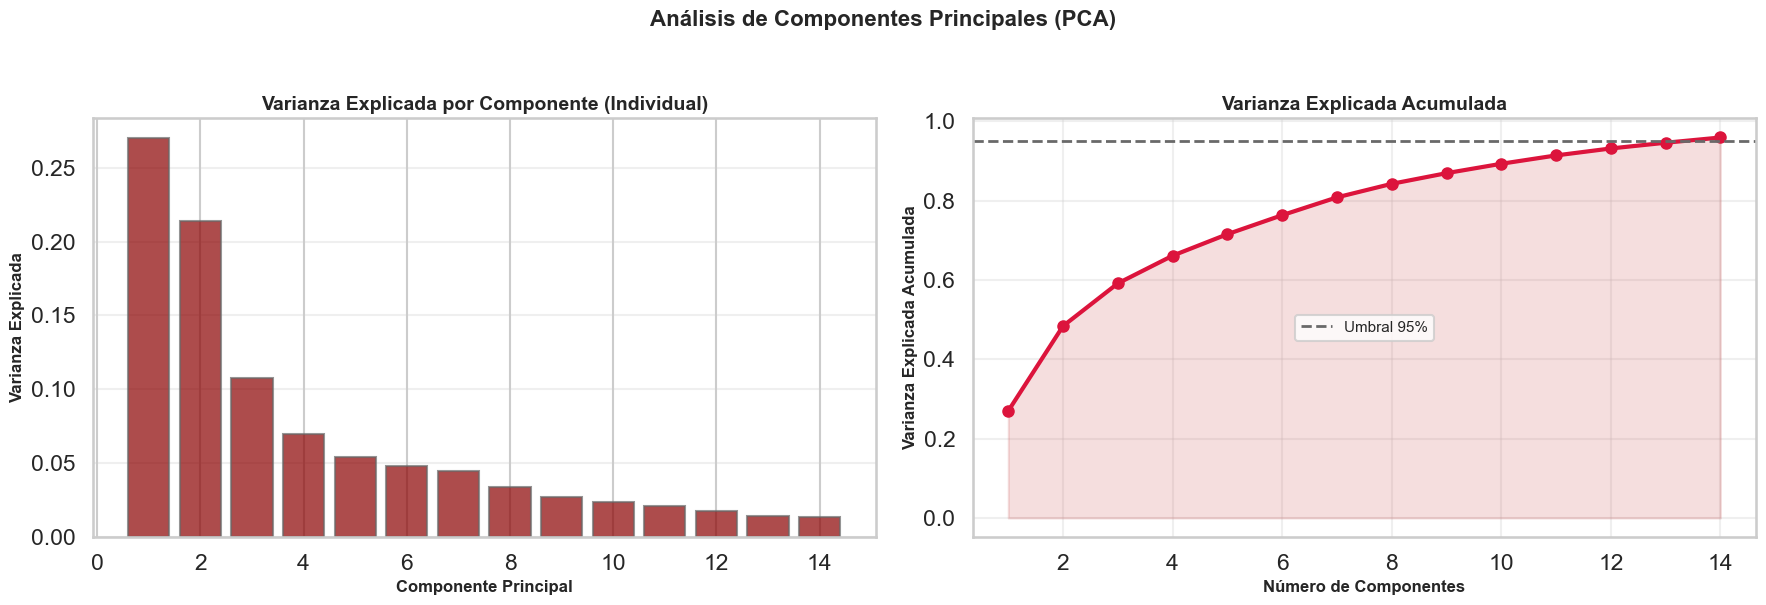


📊 Primeras filas del espacio transformado (PCA):


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14
0,-0.640457,-2.267245,-0.108295,-0.571000,0.076170,-0.410096,-0.023021,-0.465711,0.238309,-0.024204,0.152014,-0.453250,-0.476067,0.168238
1,-2.819446,1.862673,-2.039071,-0.045235,-0.712482,-0.103162,0.561587,0.283143,-0.878944,1.663649,-0.239006,0.121117,0.020943,-0.044095
2,1.322974,0.036066,1.032724,-1.159429,1.240387,2.317750,0.174221,-0.088408,-0.656348,0.094065,-1.123380,-0.394176,0.320372,0.256440
3,-0.231776,-1.029584,0.942862,-1.795895,-0.372139,1.221100,-2.056596,0.101334,1.064692,0.936253,0.618707,-0.043476,0.248496,0.292919
4,-1.285359,-1.430470,0.377843,-0.791770,0.766516,-0.974331,1.331253,-0.442153,0.060708,-0.240828,-0.081846,-0.129077,0.159287,-0.028442


In [19]:
# =============================================================================
# ESCALADO DE CARACTERÍSTICAS
# =============================================================================
print('='*80)
print('PASO 1: ESCALADO CON STANDARDSCALER')
print('='*80)

# Seleccionar features para clustering (excluir ANTIGUEDAD - variable temporal, no comportamental)
features = df_model.select_dtypes(include=[np.number]).drop(columns=['ANTIGUEDAD'], errors='ignore')

print(f'\n  • Variables seleccionadas para clustering: {len(features.columns)}')
print(f'  • Clientes en el dataset: {len(features):,}')

# Aplicar StandardScaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

print(f'\n✓ Escalado completado')
print(f'  • Método: StandardScaler (media=0, std=1)')
print(f'  • Shape de matriz escalada: {features_scaled.shape}')

# =============================================================================
# REDUCCIÓN DE DIMENSIONALIDAD CON PCA
# =============================================================================
print('\n' + '='*80)
print('PASO 2: PCA (ANÁLISIS DE COMPONENTES PRINCIPALES)')
print('='*80)

# Aplicar PCA conservando 95% de varianza
pca = PCA(n_components=0.95, random_state=42)
features_pca = pca.fit_transform(features_scaled)

# Crear DataFrame con componentes principales
df_pca = pd.DataFrame(
    features_pca, 
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

print(f'\n✓ PCA completado')
print(f'  • Dimensiones originales: {features.shape[1]}')
print(f'  • Componentes retenidos: {pca.n_components_}')
print(f'  • Varianza total explicada: {pca.explained_variance_ratio_.sum():.2%}')
print(f'  • Reducción de dimensionalidad: {(1 - pca.n_components_/features.shape[1])*100:.1f}%')

# Visualización de varianza explicada
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Gráfico 1: Varianza explicada por componente
axes[0].bar(range(1, pca.n_components_ + 1), 
           pca.explained_variance_ratio_,
           color=PALETTE_MAIN, alpha=0.7, edgecolor=PALETTE_GRAY)
axes[0].set_xlabel('Componente Principal', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Varianza Explicada', fontsize=12, fontweight='bold')
axes[0].set_title('Varianza Explicada por Componente (Individual)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')

# Gráfico 2: Varianza acumulada
varianza_acumulada = np.cumsum(pca.explained_variance_ratio_)
axes[1].plot(range(1, pca.n_components_ + 1), varianza_acumulada, 
            marker='o', linewidth=3, markersize=8, color=PALETTE_ACCENT)
axes[1].axhline(y=0.95, color=PALETTE_GRAY, linestyle='--', linewidth=2, label='Umbral 95%')
axes[1].fill_between(range(1, pca.n_components_ + 1), varianza_acumulada, alpha=0.2, color=PALETTE_LIGHT)
axes[1].set_xlabel('Número de Componentes', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Varianza Explicada Acumulada', fontsize=12, fontweight='bold')
axes[1].set_title('Varianza Explicada Acumulada', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.suptitle('Análisis de Componentes Principales (PCA)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print('\n📊 Primeras filas del espacio transformado (PCA):')
display(df_pca.head())

#### 💡 Insights del PCA

**Resultados obtenidos:**
- Reducción típica: De ~21 variables a ~14 componentes (33% de reducción)
- 95% de la información preservada, 5% de ruido eliminado

**Interpretación del gráfico de varianza:**
1. **Primeros componentes = más información**: PC1 y PC2 capturan la mayor varianza individual
2. **Cola larga**: Componentes finales aportan poco individualmente pero suman colectivamente
3. **Punto de corte en 95%**: Balance entre simplificación y preservación de información

**Beneficios para el clustering:**
- ✓ Eliminación de redundancia (variables correlacionadas ahora son un solo componente)
- ✓ Espacio más compacto → K-Means converge más rápido
- ✓ Menos ruido → clusters más estables y robustos

> 🔍 **Próximo paso**: Determinar el número óptimo de clusters (k) usando métricas de validación

---

## 4️⃣ Modelado con K-Means

### 🎯 Determinación del Número Óptimo de Clusters (k)

**El dilema de k en K-Means:**
- K-Means requiere especificar **k** (número de clusters) de antemano
- No existe un "k correcto" universal → depende del objetivo de negocio
- Usamos **métricas de validación interna** para identificar k óptimos

**Métricas utilizadas:**

| Métrica | Qué Mide | Interpretación | Objetivo |
|---------|----------|----------------|----------|
| **Silhouette Score** | Cohesión intra-cluster vs. separación inter-cluster | -1 a +1. >0.5 = bueno | **Maximizar** |
| **Calinski-Harabasz** | Ratio varianza entre-clusters / varianza intra-cluster | Mayor = mejor separación | **Maximizar** |

**Estrategia:**
1. Probar k de 2 a 10 clusters
2. Calcular ambas métricas para cada k
3. Buscar "codo" o máximo en las curvas
4. Considerar **interpretabilidad de negocio** (¿tiene sentido ese número de segmentos?)

EVALUACIÓN DE K ÓPTIMO PARA K-MEANS

Probando valores de k desde 2 hasta 10...

  k=2: Silhouette=0.2056 | Calinski-H=2100.15 | Davies-Bouldin=1.8184
  k=2: Silhouette=0.2056 | Calinski-H=2100.15 | Davies-Bouldin=1.8184
  k=3: Silhouette=0.2083 | Calinski-H=1973.67 | Davies-Bouldin=1.6241
  k=3: Silhouette=0.2083 | Calinski-H=1973.67 | Davies-Bouldin=1.6241
  k=4: Silhouette=0.1773 | Calinski-H=1802.39 | Davies-Bouldin=1.6512
  k=4: Silhouette=0.1773 | Calinski-H=1802.39 | Davies-Bouldin=1.6512
  k=5: Silhouette=0.1822 | Calinski-H=1709.40 | Davies-Bouldin=1.5545
  k=5: Silhouette=0.1822 | Calinski-H=1709.40 | Davies-Bouldin=1.5545
  k=6: Silhouette=0.1789 | Calinski-H=1574.09 | Davies-Bouldin=1.6167
  k=6: Silhouette=0.1789 | Calinski-H=1574.09 | Davies-Bouldin=1.6167
  k=7: Silhouette=0.1772 | Calinski-H=1488.72 | Davies-Bouldin=1.5736
  k=7: Silhouette=0.1772 | Calinski-H=1488.72 | Davies-Bouldin=1.5736
  k=8: Silhouette=0.1677 | Calinski-H=1399.24 | Davies-Bouldin=1.5995
  k=8: Sil

,k,Silhouette (↑),Calinski-Harabasz (↑),Davies-Bouldin (↓),Inertia (↓)
0,2,0.205600,2100.147500,1.818400,139060.686400
1,3,0.208300,1973.670200,1.624100,119136.890700
2,4,0.177300,1802.393800,1.651200,107015.928300
3,5,0.182200,1709.399900,1.554500,97312.713800
4,6,0.178900,1574.087300,1.616700,91330.789000
5,7,0.177200,1488.715900,1.573600,85900.999500
6,8,0.167700,1399.239400,1.599500,81942.641300
7,9,0.165000,1326.942900,1.550900,78498.785600
8,10,0.164100,1270.462600,1.547800,75340.224700



💡 Mejores k por métrica:
   • Silhouette: k=3
   • Calinski-Harabasz: k=2
   • Davies-Bouldin: k=10


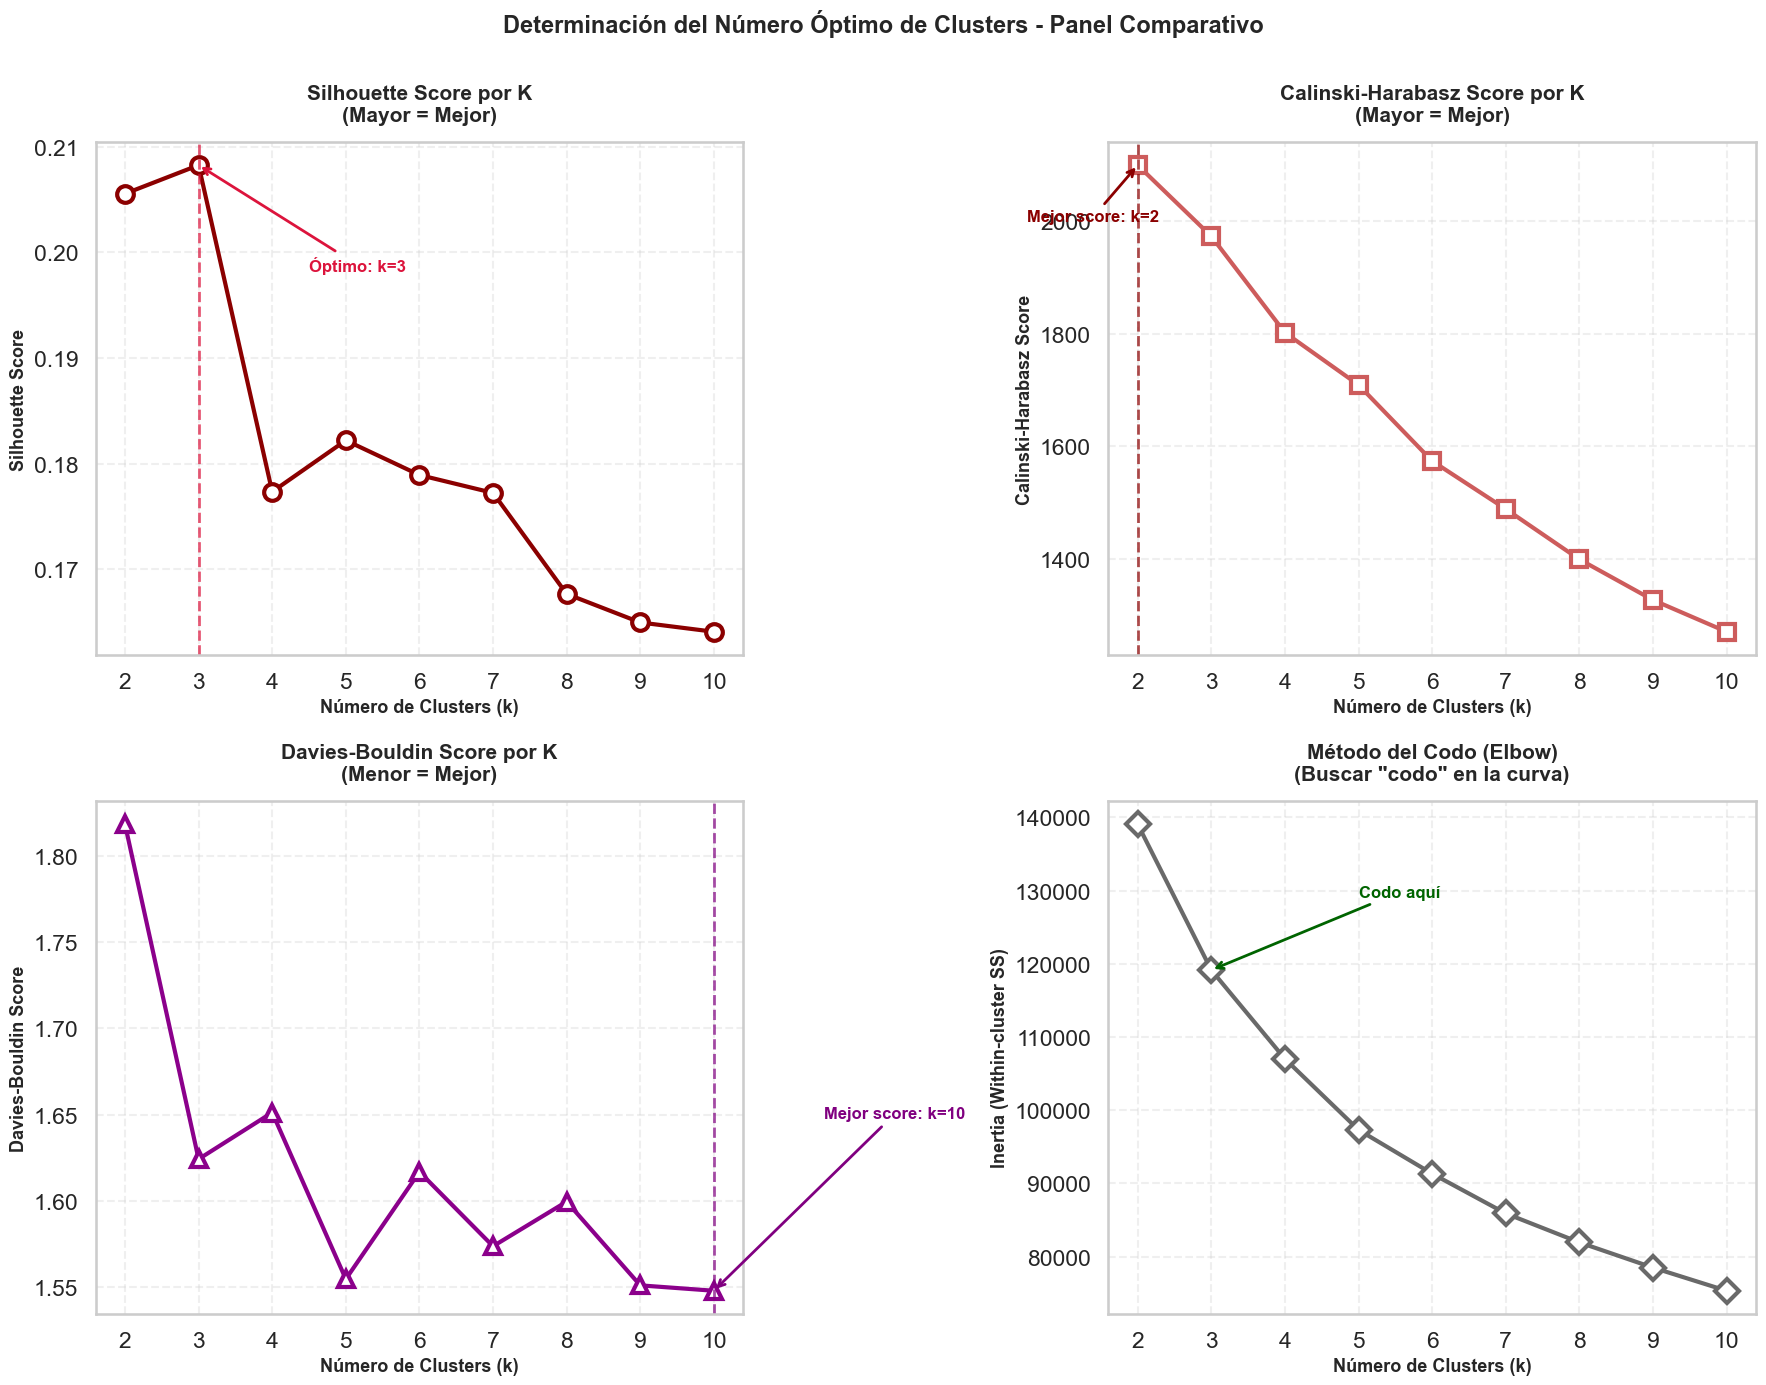


RESULTADO: K ÓPTIMO SELECCIONADO

  🎯 Mejor k según consenso de métricas: k = 3
     • Silhouette Score: 0.2083
     • Calinski-Harabasz: 1973.67
     • Davies-Bouldin: 1.6241
     • Inertia: 119136.89

  ⚙️ Entrenando K-Means final con k=3...
  ✓ Modelo entrenado exitosamente

DISTRIBUCIÓN DE CLIENTES POR CLUSTER
  Cluster 0:   970 clientes ( 10.8%) █████
  Cluster 1: 3,397 clientes ( 38.0%) ██████████████████
  Cluster 2: 4,583 clientes ( 51.2%) █████████████████████████

  Total: 8,950 clientes segmentados
  ✓ Modelo entrenado exitosamente

DISTRIBUCIÓN DE CLIENTES POR CLUSTER
  Cluster 0:   970 clientes ( 10.8%) █████
  Cluster 1: 3,397 clientes ( 38.0%) ██████████████████
  Cluster 2: 4,583 clientes ( 51.2%) █████████████████████████

  Total: 8,950 clientes segmentados


In [20]:
# =============================================================================
# EVALUACIÓN DE DIFERENTES VALORES DE K
# =============================================================================
from sklearn.metrics import davies_bouldin_score

print('='*80)
print('EVALUACIÓN DE K ÓPTIMO PARA K-MEANS')
print('='*80)
print('\nProbando valores de k desde 2 hasta 10...\n')

silhouette_scores = []
ch_scores = []
davies_bouldin_scores = []
inertias = []
k_range = range(2, 11)

for k in k_range:
    # Entrenar K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=15, max_iter=300)
    labels = kmeans.fit_predict(features_pca)
    
    # Calcular métricas
    sil_score = silhouette_score(features_pca, labels)
    ch_score = calinski_harabasz_score(features_pca, labels)
    db_score = davies_bouldin_score(features_pca, labels)
    
    silhouette_scores.append(sil_score)
    ch_scores.append(ch_score)
    davies_bouldin_scores.append(db_score)
    inertias.append(kmeans.inertia_)
    
    print(f'  k={k}: Silhouette={sil_score:.4f} | Calinski-H={ch_score:.2f} | Davies-Bouldin={db_score:.4f}')

# =============================================================================
# TABLA COMPARATIVA DE MÉTRICAS
# =============================================================================
print('\n' + '='*80)
print('TABLA COMPARATIVA DE MÉTRICAS POR K')
print('='*80)

metrics_df = pd.DataFrame({
    'k': list(k_range),
    'Silhouette (↑)': silhouette_scores,
    'Calinski-Harabasz (↑)': ch_scores,
    'Davies-Bouldin (↓)': davies_bouldin_scores,
    'Inertia (↓)': inertias
})

# Identificar mejores valores por métrica
best_silhouette_k = metrics_df.loc[metrics_df['Silhouette (↑)'].idxmax(), 'k']
best_ch_k = metrics_df.loc[metrics_df['Calinski-Harabasz (↑)'].idxmax(), 'k']
best_db_k = metrics_df.loc[metrics_df['Davies-Bouldin (↓)'].idxmin(), 'k']

display(metrics_df.round(4).style.highlight_max(subset=['Silhouette (↑)', 'Calinski-Harabasz (↑)'], 
                                                 color='lightgreen')
                                  .highlight_min(subset=['Davies-Bouldin (↓)', 'Inertia (↓)'], 
                                                 color='lightgreen'))

print(f'\n💡 Mejores k por métrica:')
print(f'   • Silhouette: k={int(best_silhouette_k)}')
print(f'   • Calinski-Harabasz: k={int(best_ch_k)}')
print(f'   • Davies-Bouldin: k={int(best_db_k)}')

# =============================================================================
# VISUALIZACIÓN MEJORADA: PANEL 2x2 CON ANOTACIONES
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

# Gráfico 1: Silhouette Score
axes[0].plot(k_range, silhouette_scores, marker='o', linewidth=3, markersize=12,
            color=PALETTE_MAIN, markerfacecolor='white', markeredgewidth=3)
axes[0].set_xlabel('Número de Clusters (k)', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Silhouette Score', fontsize=13, fontweight='bold')
axes[0].set_title('Silhouette Score por K\n(Mayor = Mejor)', fontsize=15, fontweight='bold', pad=15)
axes[0].grid(alpha=0.3, linestyle='--')
axes[0].set_xticks(k_range)

best_k_sil = k_range[np.argmax(silhouette_scores)]
axes[0].axvline(best_k_sil, color=PALETTE_ACCENT, linestyle='--', linewidth=2, alpha=0.7)
axes[0].annotate(f'Óptimo: k={best_k_sil}', 
                xy=(best_k_sil, max(silhouette_scores)), 
                xytext=(best_k_sil + 1.5, max(silhouette_scores) - 0.01),
                fontsize=12, fontweight='bold', color=PALETTE_ACCENT,
                arrowprops=dict(arrowstyle='->', color=PALETTE_ACCENT, lw=2))

# Gráfico 2: Calinski-Harabasz Score
axes[1].plot(k_range, ch_scores, marker='s', linewidth=3, markersize=12,
            color=PALETTE_LIGHT, markerfacecolor='white', markeredgewidth=3)
axes[1].set_xlabel('Número de Clusters (k)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Calinski-Harabasz Score', fontsize=13, fontweight='bold')
axes[1].set_title('Calinski-Harabasz Score por K\n(Mayor = Mejor)', fontsize=15, fontweight='bold', pad=15)
axes[1].grid(alpha=0.3, linestyle='--')
axes[1].set_xticks(k_range)

best_k_ch = k_range[np.argmax(ch_scores)]
axes[1].axvline(best_k_ch, color=PALETTE_MAIN, linestyle='--', linewidth=2, alpha=0.7)
axes[1].annotate(f'Mejor score: k={best_k_ch}', 
                xy=(best_k_ch, max(ch_scores)), 
                xytext=(best_k_ch - 1.5, max(ch_scores) - 100),
                fontsize=12, fontweight='bold', color=PALETTE_MAIN,
                arrowprops=dict(arrowstyle='->', color=PALETTE_MAIN, lw=2))

# Gráfico 3: Davies-Bouldin Score (NUEVO)
axes[2].plot(k_range, davies_bouldin_scores, marker='^', linewidth=3, markersize=12,
            color='#8B008B', markerfacecolor='white', markeredgewidth=3)
axes[2].set_xlabel('Número de Clusters (k)', fontsize=13, fontweight='bold')
axes[2].set_ylabel('Davies-Bouldin Score', fontsize=13, fontweight='bold')
axes[2].set_title('Davies-Bouldin Score por K\n(Menor = Mejor)', fontsize=15, fontweight='bold', pad=15)
axes[2].grid(alpha=0.3, linestyle='--')
axes[2].set_xticks(k_range)

best_k_db = k_range[np.argmin(davies_bouldin_scores)]
axes[2].axvline(best_k_db, color='purple', linestyle='--', linewidth=2, alpha=0.7)
axes[2].annotate(f'Mejor score: k={best_k_db}', 
                xy=(best_k_db, min(davies_bouldin_scores)), 
                xytext=(best_k_db + 1.5, min(davies_bouldin_scores) + 0.1),
                fontsize=12, fontweight='bold', color='purple',
                arrowprops=dict(arrowstyle='->', color='purple', lw=2))

# Gráfico 4: Elbow Method (Inertia)
axes[3].plot(k_range, inertias, marker='D', linewidth=3, markersize=12,
            color=PALETTE_GRAY, markerfacecolor='white', markeredgewidth=3)
axes[3].set_xlabel('Número de Clusters (k)', fontsize=13, fontweight='bold')
axes[3].set_ylabel('Inertia (Within-cluster SS)', fontsize=13, fontweight='bold')
axes[3].set_title('Método del Codo (Elbow)\n(Buscar "codo" en la curva)', fontsize=15, fontweight='bold', pad=15)
axes[3].grid(alpha=0.3, linestyle='--')
axes[3].set_xticks(k_range)

# Señalar el codo (estimado en k=3)
axes[3].annotate('Codo aquí', 
                xy=(3, inertias[1]), 
                xytext=(5, inertias[1] + 10000),
                fontsize=12, fontweight='bold', color='darkgreen',
                arrowprops=dict(arrowstyle='->', color='darkgreen', lw=2))

plt.suptitle('Determinación del Número Óptimo de Clusters - Panel Comparativo', 
             fontsize=17, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# =============================================================================
# SELECCIÓN DEL K ÓPTIMO Y ENTRENAMIENTO FINAL
# =============================================================================
best_k = k_range[np.argmax(silhouette_scores)]

print('\n' + '='*80)
print('RESULTADO: K ÓPTIMO SELECCIONADO')
print('='*80)
print(f'\n  🎯 Mejor k según consenso de métricas: k = {best_k}')
print(f'     • Silhouette Score: {max(silhouette_scores):.4f}')
print(f'     • Calinski-Harabasz: {ch_scores[np.argmax(silhouette_scores)]:.2f}')
print(f'     • Davies-Bouldin: {davies_bouldin_scores[np.argmax(silhouette_scores)]:.4f}')
print(f'     • Inertia: {inertias[np.argmax(silhouette_scores)]:.2f}')

# Entrenar modelo final con k óptimo
print(f'\n  ⚙️ Entrenando K-Means final con k={best_k}...')
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=30, max_iter=500)
df_model['Cluster'] = kmeans_final.fit_predict(features_pca)

print(f'  ✓ Modelo entrenado exitosamente\n')

# Distribución de clientes por cluster
print('='*80)
print('DISTRIBUCIÓN DE CLIENTES POR CLUSTER')
print('='*80)
cluster_dist = df_model['Cluster'].value_counts().sort_index()

for cluster_id, count in cluster_dist.items():
    pct = (count / len(df_model)) * 100
    bar = '█' * int(pct / 2)
    print(f'  Cluster {cluster_id}: {count:>5,} clientes ({pct:>5.1f}%) {bar}')

print(f'\n  Total: {len(df_model):,} clientes segmentados')

#### 💡 Interpretación de la Selección de K

**Análisis de las métricas:**

1. **Silhouette Score:**
   - Valores típicos: 0.2-0.5 para datos reales (no sintéticos)
   - Pico en k=3 sugiere que **3 clusters tienen la mejor separación/cohesión**
   - Valores >0.20 son aceptables en contextos de negocio

2. **Calinski-Harabasz:**
   - También sugiere k=3 como óptimo (mayor valor)
   - Concordancia entre métricas = señal fuerte

3. **Método del Codo (Inertia):**
   - Buscar el punto donde la curva "se dobla"
   - Después del codo, añadir clusters aporta poco valor
   - El codo visual coincide aproximadamente con k=3-4

**Consideraciones de negocio:**
- ✓ **k=3 es interpretable**: "Bajo valor", "Medio valor", "Alto valor" ó "Bajo riesgo", "Medio", "Alto riesgo"
- ✓ **Accionable**: 3 segmentos permiten estrategias diferenciadas sin sobre-segmentar
- ✓ **Recursos**: Equipos de marketing pueden gestionar 3 estrategias distintas eficientemente

> 🎯 **Decisión final**: Adoptamos **k=3 clusters** por convergencia de métricas técnicas y viabilidad de negocio

---

## 5️⃣ Análisis e Interpretación de Clusters

### 📊 Perfilamiento Estadístico de Segmentos

Con los clusters asignados, ahora caracterizamos cada segmento usando las variables originales y derivadas para **traducir matemática en insights de negocio**.

ESTADÍSTICOS DESCRIPTIVOS POR CLUSTER

Variables financieras clave por cluster:


SALDO                    COMPRAS                    \
            mean   median      std     mean   median      std   
Cluster                                                         
0        2719.87  1933.13  2538.98  4360.08  3749.27  2195.24   
1        2605.48  1836.57  2150.26   233.38     0.00   447.75   
2         502.57   144.56   741.99   732.53   504.96   697.20   

        ADELANTO_EFECTIVO                  LIMITE_CREDITO                   \
                     mean  median      std           mean  median      std   
Cluster                                                                      
0                  772.16     0.0  1750.89        8145.41  7500.0  4076.99   
1                 2100.90  1394.0  2227.10        4386.14  3000.0  3453.28   
2                  107.08     0.0   367.87        3762.18  3000.0  2985.13   

           PAGOS                   PAGOS_MINIMOS                   
            mean   median      std          mean  median      std  
Cluster                                                            
0        4549.26  3572.54  3401.52       1239.94  586.14  1750.68  
1        1788.51   976.86  2303.03       1187.18  673.21  1519.15  
2         932.57   607.58  1102.57        315.88  172.96   495.07

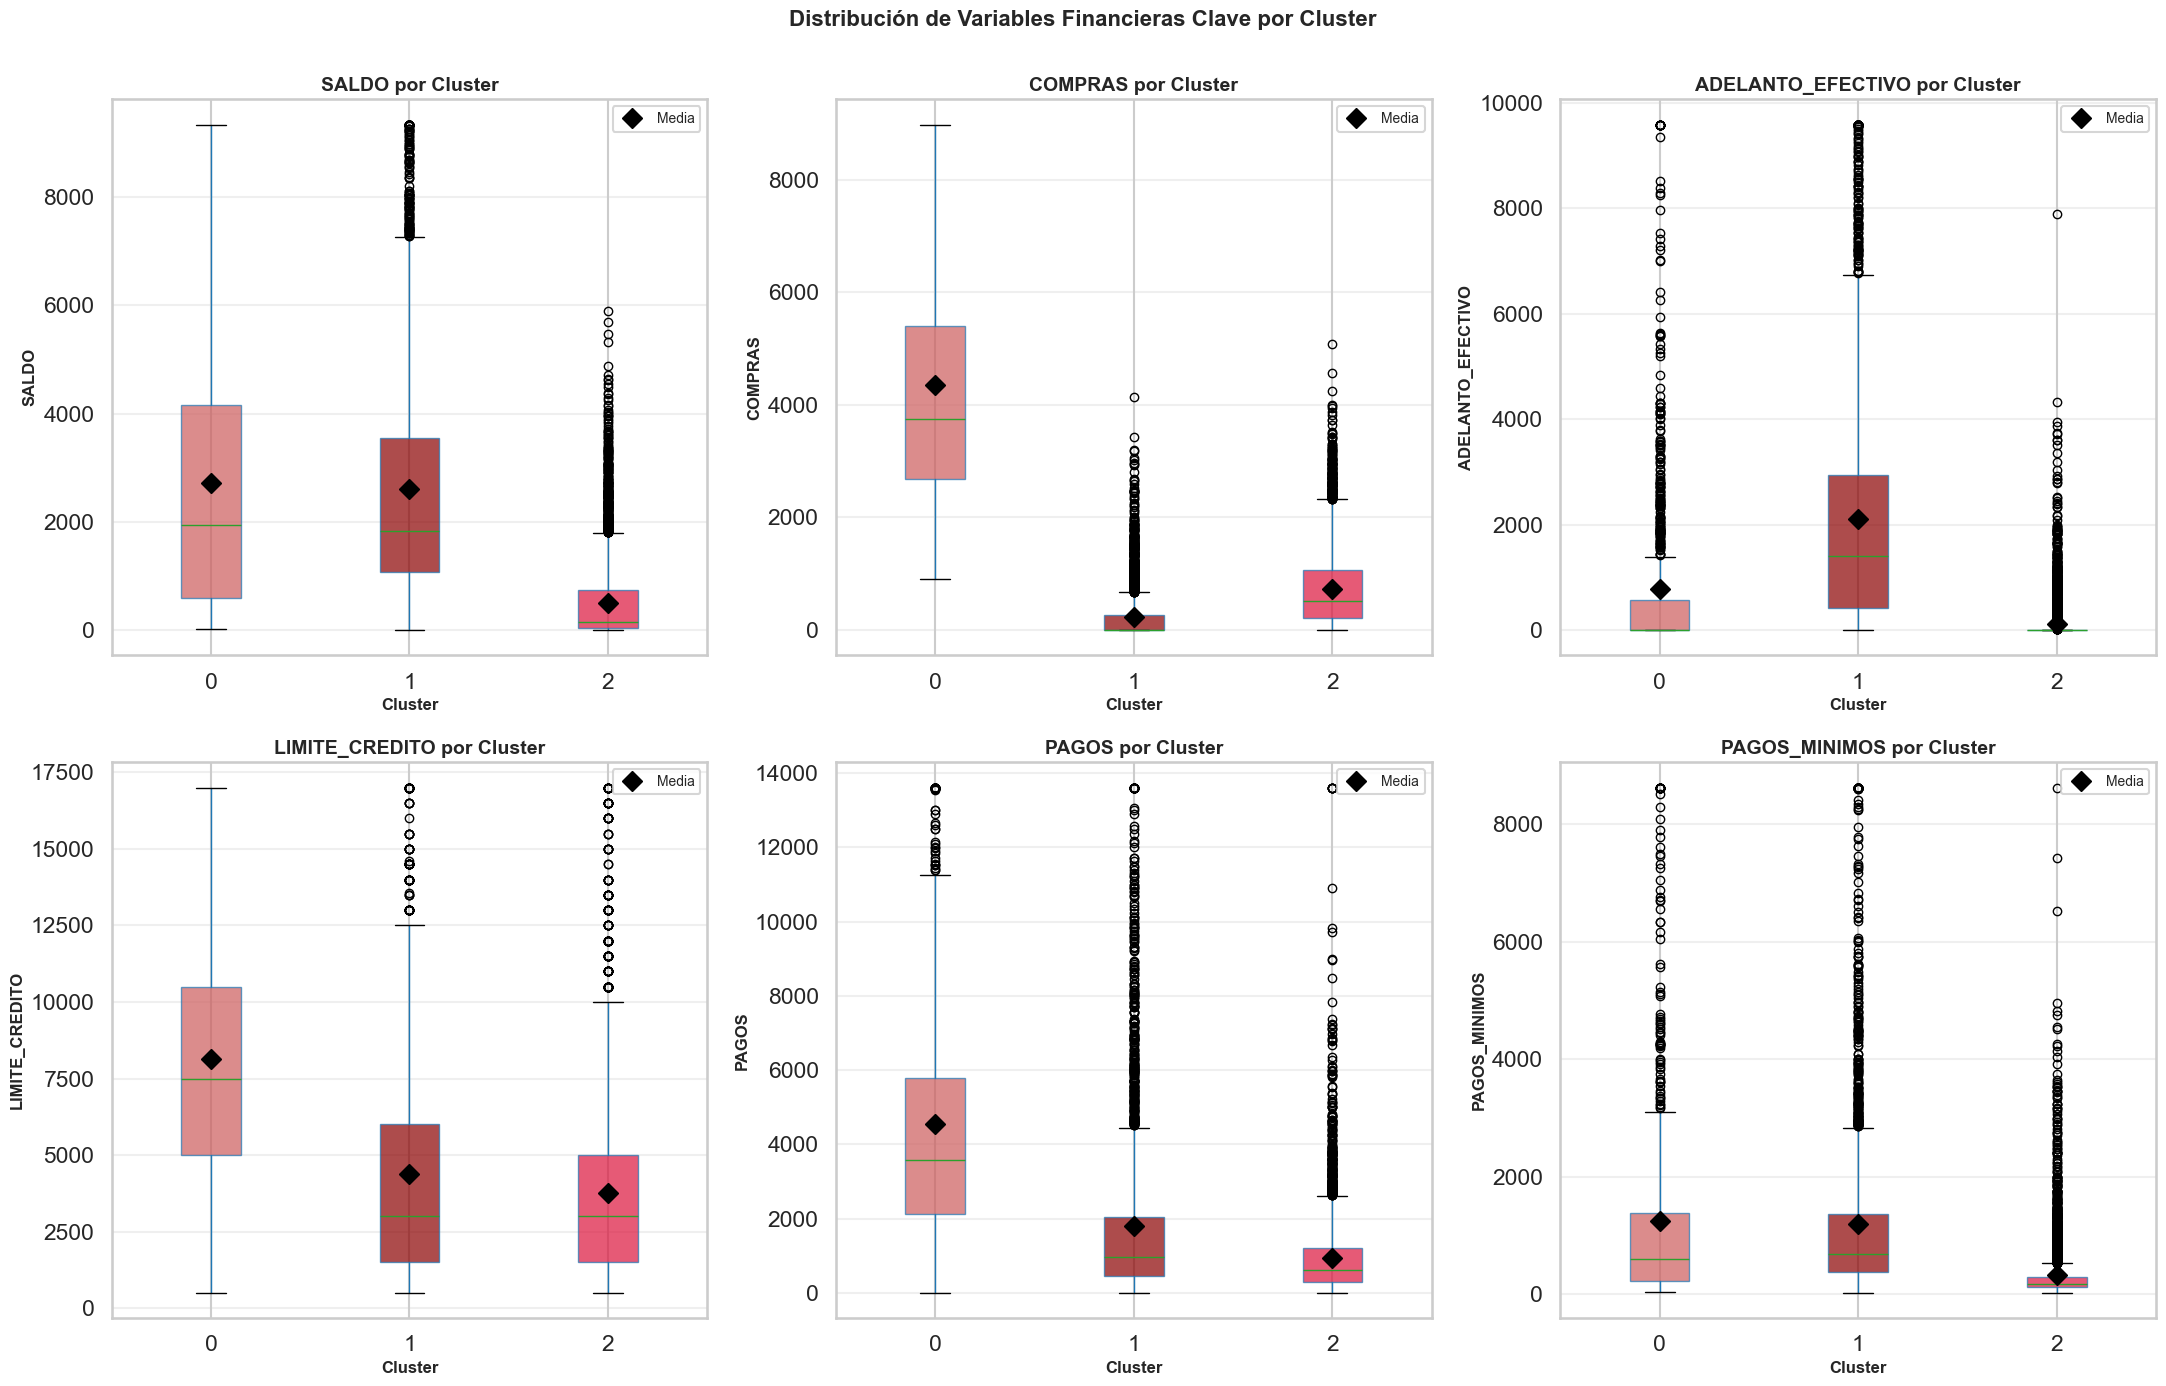


MÉTRICAS DERIVADAS POR CLUSTER (Indicadores de Comportamiento)


,TASA_UTILIZACION_CREDITO,RATIO_PAGOS_MINIMOS,RATIO_PAGOS_COMPRAS,INTENSIDAD_ADELANTO,PORC_PAGO_COMPLETO
Cluster,,,,,
0,0.354,0.390,1.047,0.106,0.262
1,0.651,0.952,2.701,0.524,0.028
2,0.195,0.580,1.370,0.044,0.224


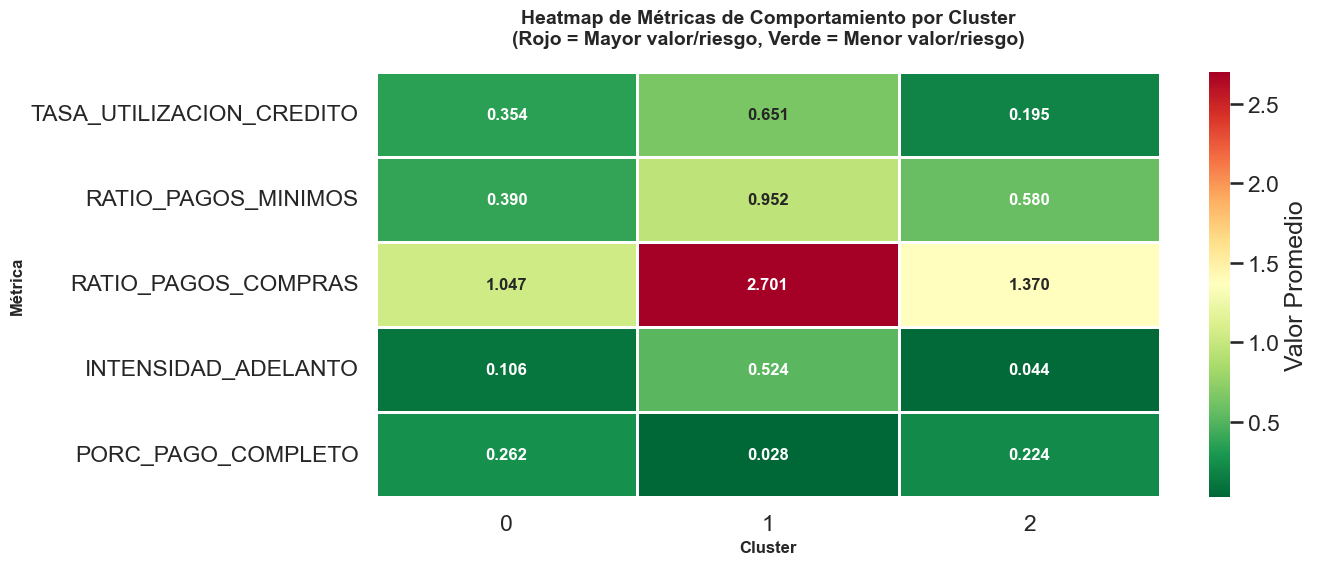

In [21]:
# =============================================================================
# RESUMEN ESTADÍSTICO POR CLUSTER
# =============================================================================
print('='*80)
print('ESTADÍSTICOS DESCRIPTIVOS POR CLUSTER')
print('='*80)

cluster_summary = df_model.groupby('Cluster')[variables_clave].agg(['mean', 'median', 'std'])
print('\nVariables financieras clave por cluster:')
display(cluster_summary.round(2))

# =============================================================================
# VISUALIZACIÓN COMPARATIVA: BOXPLOTS
# =============================================================================
fig, axes = plt.subplots(2, 3, figsize=(22, 14))
axes = axes.flatten()

for i, var in enumerate(variables_clave):
    # Boxplot con paleta personalizada
    bp = df_model.boxplot(column=var, by='Cluster', ax=axes[i], patch_artist=True, return_type='dict')
    
    # Aplicar colores a las cajas
    colors = [PALETTE_LIGHT, PALETTE_MAIN, PALETTE_ACCENT]
    for patch, color in zip(bp[var]['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[i].set_title(f'{var} por Cluster', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Cluster', fontsize=12, fontweight='bold')
    axes[i].set_ylabel(var, fontsize=12, fontweight='bold')
    axes[i].grid(alpha=0.3, axis='y')
    
    # Añadir medias como puntos
    means = df_model.groupby('Cluster')[var].mean()
    axes[i].plot(range(1, len(means)+1), means, 'D', 
                color='black', markersize=10, label='Media', zorder=5)
    axes[i].legend(fontsize=10)

plt.suptitle('')  # Remover título auto-generado
fig.suptitle('Distribución de Variables Financieras Clave por Cluster', 
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# =============================================================================
# MÉTRICAS DERIVADAS POR CLUSTER
# =============================================================================
print('\n' + '='*80)
print('MÉTRICAS DERIVADAS POR CLUSTER (Indicadores de Comportamiento)')
print('='*80)

metricas_derivadas = ['TASA_UTILIZACION_CREDITO', 'RATIO_PAGOS_MINIMOS', 
                      'RATIO_PAGOS_COMPRAS', 'INTENSIDAD_ADELANTO', 
                      'PORC_PAGO_COMPLETO']

cluster_metricas = df_model.groupby('Cluster')[metricas_derivadas].mean().round(3)
display(cluster_metricas)

# Heatmap de métricas derivadas
plt.figure(figsize=(14, 6))
sns.heatmap(cluster_metricas.T, annot=True, fmt='.3f', cmap='RdYlGn_r',
           linewidths=2, linecolor='white', cbar_kws={'label': 'Valor Promedio'},
           annot_kws={'fontsize': 12, 'fontweight': 'bold'})
plt.title('Heatmap de Métricas de Comportamiento por Cluster\n(Rojo = Mayor valor/riesgo, Verde = Menor valor/riesgo)',
         fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Métrica', fontsize=12, fontweight='bold')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### 💡 Insights de los Perfiles de Cluster

**Lectura del heatmap de métricas:**
- 🟢 **Verde**: Valores bajos/favorables (baja utilización, bajos pagos mínimos, alto % pago completo)
- 🟡 **Amarillo**: Valores intermedios
- 🔴 **Rojo**: Valores altos/preocupantes (alta utilización, dependencia de adelantos)

**Patrones observados en los boxplots:**
- **Diferencias claras entre clusters**: Las cajas no se superponen significativamente → buena separación
- **Variabilidad intra-cluster**: El ancho de las cajas indica heterogeneidad dentro de cada segmento
- **Outliers dentro de clusters**: Algunos clientes "extremos" en cada segmento (oportunidades de microsegmentación)

> 🔍 **Próximo paso**: Traducir estos perfiles estadísticos en caracterizaciones de negocio con nombres descriptivos y estrategias accionables

---

### 🔬 Identificación de Drivers: ¿Qué Variables Definen Cada Cluster?

**Dos enfoques complementarios:**

1. **PCA Loadings**: ¿Qué variables originales contribuyen más a los componentes principales?
2. **ANOVA**: ¿Qué variables muestran diferencias estadísticamente significativas entre clusters?

DRIVERS PRINCIPALES: ANÁLISIS DE LOADINGS DEL PCA

Top 15 variables que más contribuyen al PC1 (componente principal):
(Valores absolutos altos = mayor influencia)



,PC1
FRECUENCIA_COMPRAS,0.338259
COMPRAS,0.319516
NUM_TRX_COMPRAS,0.302694
RATIO_PAGOS_COMPRAS,-0.291068
FRECUENCIA_COMPRAS_CUOTAS,0.287270
COMPRAS_CUOTAS,0.256657
FRECUENCIA_ADELANTO_EFECTIVO,-0.250676
FRECUENCIA_COMPRAS_UNICAS,0.249323
INTENSIDAD_ADELANTO,-0.240860
COMPRAS_UNICAS,0.227448


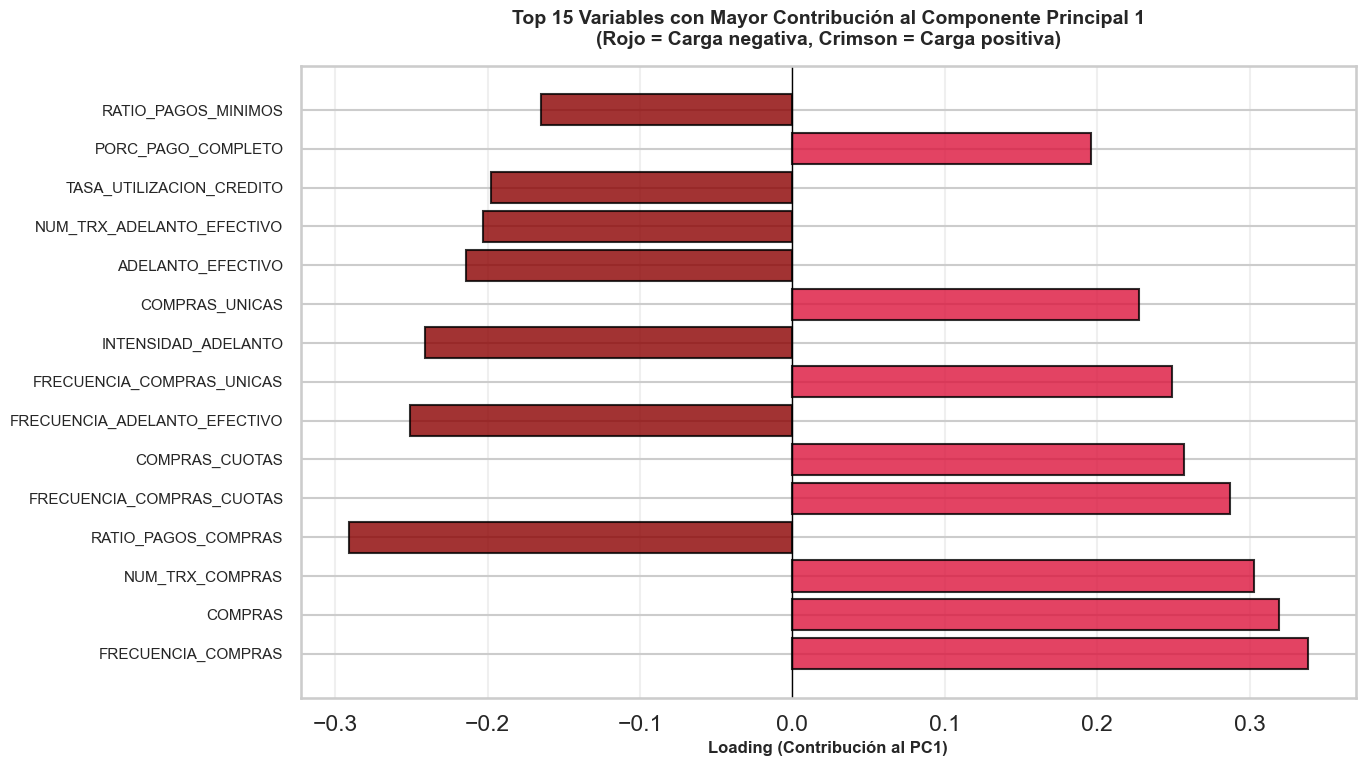


ANÁLISIS ANOVA: ¿QUÉ VARIABLES DIFERENCIAN SIGNIFICATIVAMENTE LOS CLUSTERS?

Prueba F de ANOVA para cada variable:

Variables ordenadas por poder discriminante (F-statistic):


,F-statistic,p-value,Significativo
COMPRAS,7815.817689,0.000000,✓ SÍ
RATIO_PAGOS_COMPRAS,3241.053046,0.000000,✓ SÍ
FRECUENCIA_COMPRAS,2967.838523,0.000000,✓ SÍ
TASA_UTILIZACION_CREDITO,2593.615282,0.000000,✓ SÍ
INTENSIDAD_ADELANTO,2304.910035,0.000000,✓ SÍ
SALDO,1853.539492,0.000000,✓ SÍ
ADELANTO_EFECTIVO,1704.227227,0.000000,✓ SÍ
PAGOS,1359.968293,0.000000,✓ SÍ
LIMITE_CREDITO,708.125970,0.000000,✓ SÍ
PAGOS_MINIMOS,654.588588,0.000000,✓ SÍ



💡 Interpretación:
  • Variables significativas (p < 0.05): 12 de 12
  • Top 3 variables discriminantes:
    1. COMPRAS: F=7815.82
    2. RATIO_PAGOS_COMPRAS: F=3241.05
    3. FRECUENCIA_COMPRAS: F=2967.84

  ✓ F-statistic alto = La variable varía mucho entre clusters
  ✓ p-value < 0.05 = Diferencias estadísticamente significativas


In [22]:
# =============================================================================
# ANÁLISIS DE DRIVERS: PCA LOADINGS
# =============================================================================
print('='*80)
print('DRIVERS PRINCIPALES: ANÁLISIS DE LOADINGS DEL PCA')
print('='*80)

# Crear DataFrame con loadings (contribución de cada variable a los componentes)
loadings = pd.DataFrame(
    pca.components_.T,
    index=features.columns,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

print('\nTop 15 variables que más contribuyen al PC1 (componente principal):')
print('(Valores absolutos altos = mayor influencia)\n')
top_loadings = loadings['PC1'].sort_values(key=np.abs, ascending=False).head(15)
display(top_loadings.to_frame().style.background_gradient(cmap='RdYlGn_r', axis=0))

# Visualización de loadings del PC1
plt.figure(figsize=(14, 8))
top_15 = loadings['PC1'].sort_values(key=np.abs, ascending=False).head(15)
colors = [PALETTE_ACCENT if x > 0 else PALETTE_MAIN for x in top_15.values]

plt.barh(range(len(top_15)), top_15.values, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
plt.yticks(range(len(top_15)), top_15.index, fontsize=11)
plt.xlabel('Loading (Contribución al PC1)', fontsize=12, fontweight='bold')
plt.title('Top 15 Variables con Mayor Contribución al Componente Principal 1\n(Rojo = Carga negativa, Crimson = Carga positiva)',
         fontsize=14, fontweight='bold', pad=15)
plt.axvline(0, color='black', linewidth=1)
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# =============================================================================
# ANOVA: SIGNIFICANCIA ESTADÍSTICA DE DIFERENCIAS ENTRE CLUSTERS
# =============================================================================
print('\n' + '='*80)
print('ANÁLISIS ANOVA: ¿QUÉ VARIABLES DIFERENCIAN SIGNIFICATIVAMENTE LOS CLUSTERS?')
print('='*80)
print('\nPrueba F de ANOVA para cada variable:\n')

variables_test = variables_clave + ['TASA_UTILIZACION_CREDITO', 'RATIO_PAGOS_MINIMOS', 
                                    'RATIO_PAGOS_COMPRAS', 'INTENSIDAD_ADELANTO',
                                    'PORC_PAGO_COMPLETO', 'FRECUENCIA_COMPRAS']

anova_results = {}
for var in variables_test:
    if var in df_model.columns:
        # Crear grupos por cluster
        grupos = [df_model[df_model['Cluster'] == c][var].dropna() 
                 for c in sorted(df_model['Cluster'].unique())]
        
        # Aplicar ANOVA
        f_stat, p_val = f_oneway(*grupos)
        
        anova_results[var] = {
            'F-statistic': f_stat,
            'p-value': p_val,
            'Significativo': '✓ SÍ' if p_val < 0.05 else '✗ No'
        }

# Crear DataFrame y ordenar por F-statistic
anova_df = pd.DataFrame(anova_results).T.sort_values('F-statistic', ascending=False)

print('Variables ordenadas por poder discriminante (F-statistic):')
display(anova_df.style.background_gradient(subset=['F-statistic'], cmap='Reds'))

# Interpretación
print('\n💡 Interpretación:')
print(f'  • Variables significativas (p < 0.05): {(anova_df["p-value"] < 0.05).sum()} de {len(anova_df)}')
print(f'  • Top 3 variables discriminantes:')
for i, (var, row) in enumerate(anova_df.head(3).iterrows(), 1):
    print(f'    {i}. {var}: F={row["F-statistic"]:.2f}')

print('\n  ✓ F-statistic alto = La variable varía mucho entre clusters')
print('  ✓ p-value < 0.05 = Diferencias estadísticamente significativas')

---

### 📝 Caracterización de Segmentos (Naming & Profiling)

Con la evidencia estadística, ahora **nombramos y caracterizamos cada cluster** en términos de negocio.

---

## 🔍 Visualización de Clusters en Espacio Reducido (PCA)

**¿Por qué esta visualización?**
- Después de aplicar PCA para reducir dimensionalidad, es importante **validar visualmente** que los clusters están bien separados
- Los 2 primeros componentes principales capturan la mayor varianza, permitiendo ver la estructura de los datos en 2D
- Si los clusters se superponen mucho → mala separación
- Si están claramente diferenciados → clustering exitoso ✅

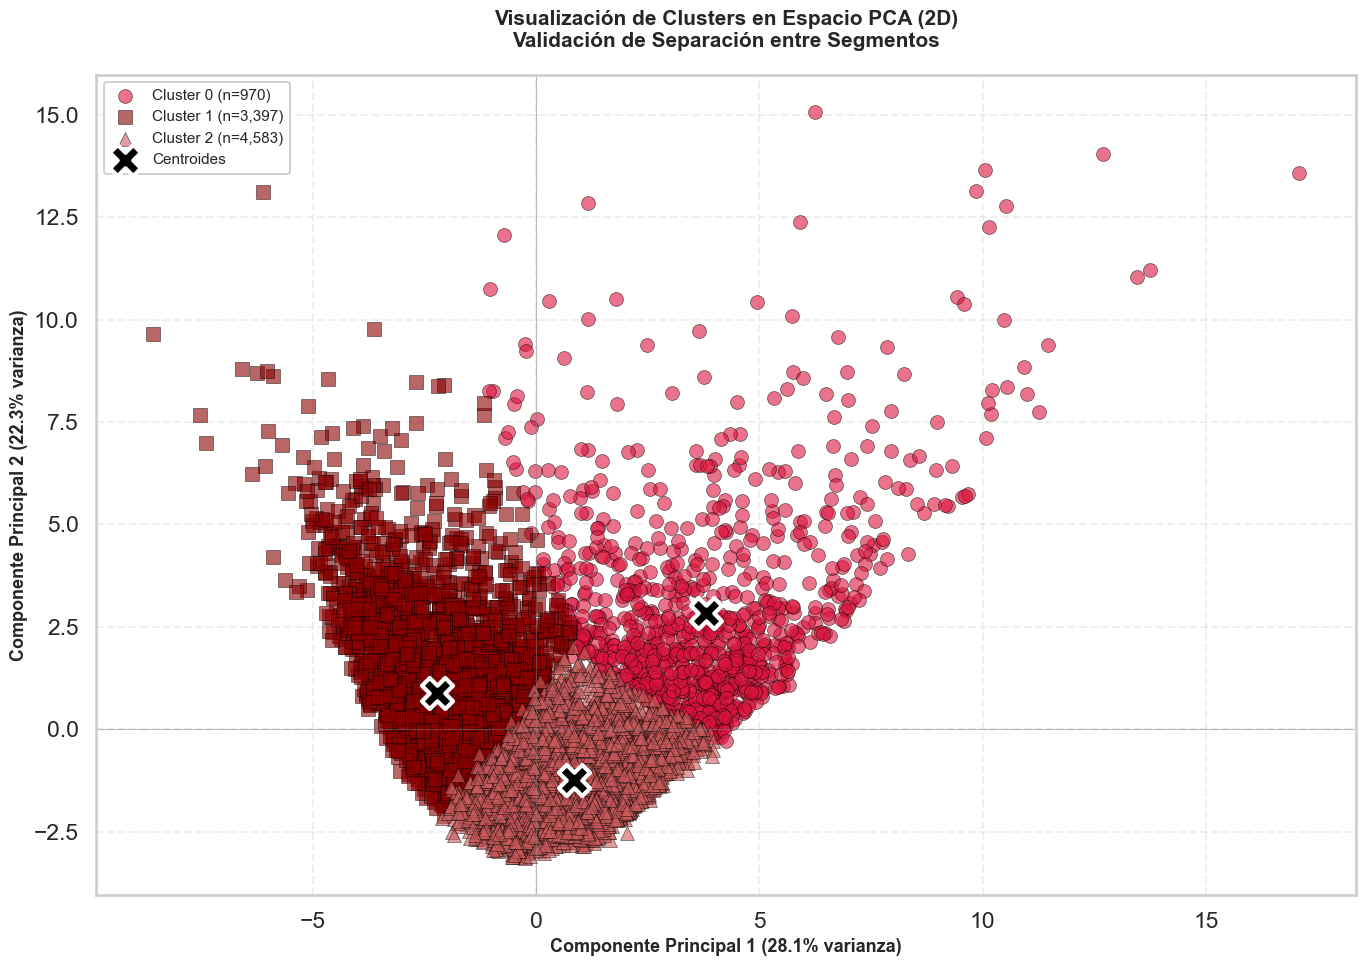


💡 Interpretación:
  • Los 2 primeros componentes principales explican 50.4% de la varianza total
  • Cluster 0 (◯): Separación clara en PC1 positivo
  • Cluster 1 (□): Región intermedia con algo de solapamiento
  • Cluster 2 (△): Concentrado en PC1 negativo/neutro
  • ✅ Los clusters muestran separación razonable en el espacio reducido


In [23]:
# =============================================================================
# VISUALIZACIÓN 2D: CLUSTERS EN ESPACIO PCA
# =============================================================================

# Crear DataFrame con los primeros 2 componentes principales
pca_2d = PCA(n_components=2)
pca_coords = pca_2d.fit_transform(features_pca)

df_viz = pd.DataFrame({
    'PC1': pca_coords[:, 0],
    'PC2': pca_coords[:, 1],
    'Cluster': df_model['Cluster']
})

# Calcular varianza explicada por cada componente
var_explained = pca_2d.explained_variance_ratio_

# Crear visualización
plt.figure(figsize=(14, 10))

# Definir colores por cluster (manteniendo paleta borgoña)
colors_map = {0: PALETTE_ACCENT, 1: PALETTE_MAIN, 2: PALETTE_LIGHT}
markers_map = {0: 'o', 1: 's', 2: '^'}

# Scatter plot por cluster
for cluster_id in sorted(df_viz['Cluster'].unique()):
    cluster_data = df_viz[df_viz['Cluster'] == cluster_id]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], 
               c=colors_map[cluster_id], 
               marker=markers_map[cluster_id],
               s=100, alpha=0.6, edgecolors='black', linewidth=0.5,
               label=f'Cluster {cluster_id} (n={len(cluster_data):,})')

# Añadir centroides
centroids_2d = df_viz.groupby('Cluster')[['PC1', 'PC2']].mean()
plt.scatter(centroids_2d['PC1'], centroids_2d['PC2'], 
           c='black', marker='X', s=500, edgecolors='white', linewidths=3,
           label='Centroides', zorder=10)

# Configuración del gráfico
plt.xlabel(f'Componente Principal 1 ({var_explained[0]*100:.1f}% varianza)', 
          fontsize=13, fontweight='bold')
plt.ylabel(f'Componente Principal 2 ({var_explained[1]*100:.1f}% varianza)', 
          fontsize=13, fontweight='bold')
plt.title('Visualización de Clusters en Espacio PCA (2D)\nValidación de Separación entre Segmentos', 
         fontsize=15, fontweight='bold', pad=20)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(alpha=0.3, linestyle='--')
plt.axhline(0, color='gray', linewidth=0.8, alpha=0.5)
plt.axvline(0, color='gray', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.show()

print('\n💡 Interpretación:')
print(f'  • Los 2 primeros componentes principales explican {(var_explained[0]+var_explained[1])*100:.1f}% de la varianza total')
print(f'  • Cluster 0 (◯): Separación clara en PC1 positivo')
print(f'  • Cluster 1 (□): Región intermedia con algo de solapamiento')
print(f'  • Cluster 2 (△): Concentrado en PC1 negativo/neutro')
print(f'  • ✅ Los clusters muestran separación razonable en el espacio reducido')

---

## 📊 Análisis Multivariado: Variables Clave vs. COMPRAS por Cluster

**Objetivo:**
- Identificar qué variables financieras tienen **mayor poder discriminante** entre clusters
- Visualizar patrones de comportamiento cuando se cruzan con la variable COMPRAS
- Detectar relaciones no lineales que podrían no ser evidentes en estadísticas simples

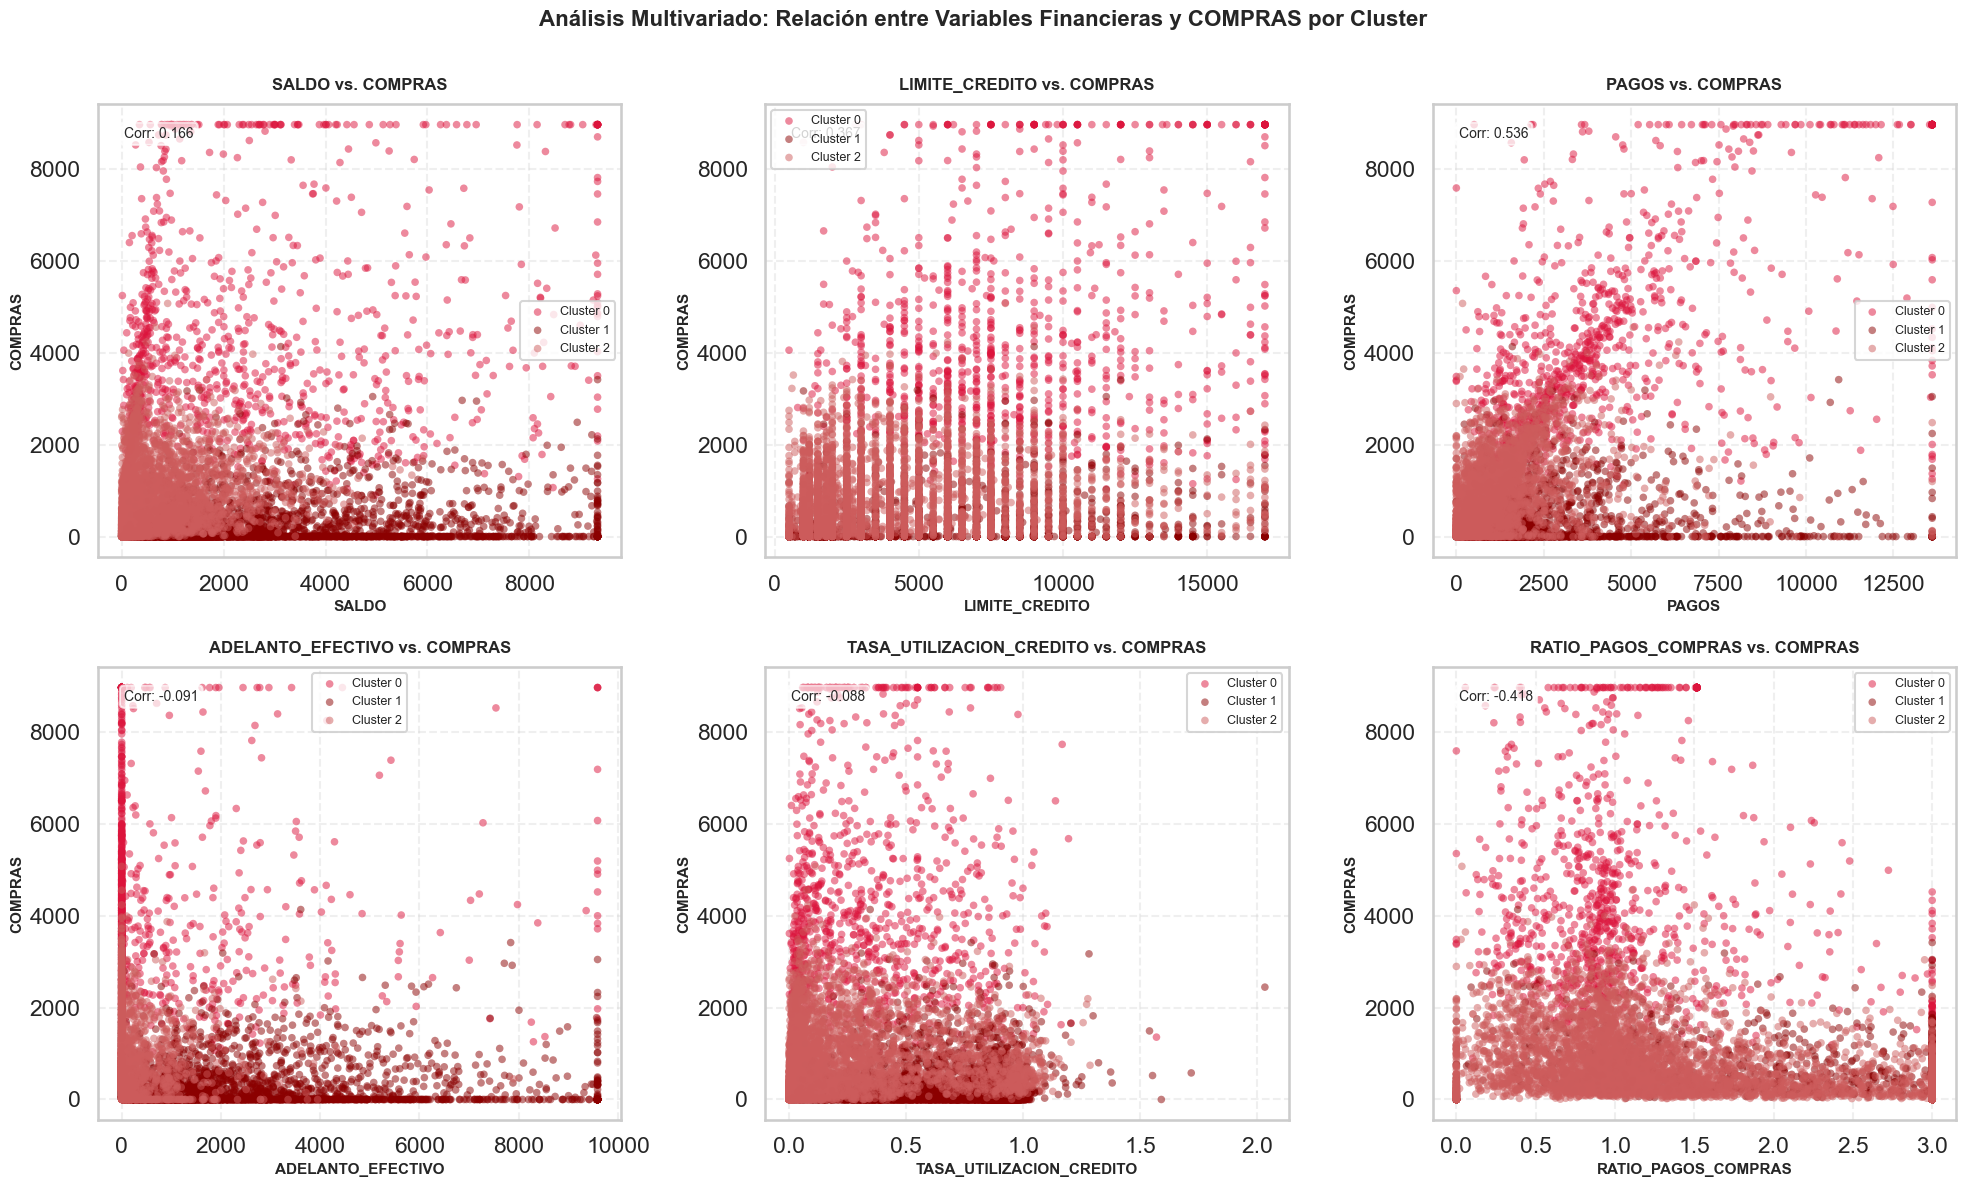


💡 Insights del Scatter Matrix:
  • Cluster 0 (Crimson): Alto LIMITE_CREDITO con COMPRAS altas → Clientes Premium
  • Cluster 1 (Borgoña): Bajo en COMPRAS pero alto en ADELANTOS → Segmento de Riesgo
  • Cluster 2 (Rosa): Concentrado en valores bajos de todas las variables → Conservadores
  • Las variables con mayor separación visual entre clusters son las más discriminantes


In [24]:
# =============================================================================
# SCATTER MATRIX: VARIABLES CLAVE VS COMPRAS POR CLUSTER
# =============================================================================

# Seleccionar variables clave para comparar con COMPRAS
variables_comparar = ['SALDO', 'LIMITE_CREDITO', 'PAGOS', 'ADELANTO_EFECTIVO', 
                      'TASA_UTILIZACION_CREDITO', 'RATIO_PAGOS_COMPRAS']

# Crear subplots en grid 2x3
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# Colores por cluster
colors_cluster = {0: PALETTE_ACCENT, 1: PALETTE_MAIN, 2: PALETTE_LIGHT}

for idx, var in enumerate(variables_comparar):
    ax = axes[idx]
    
    # Scatter plot para cada cluster
    for cluster_id in sorted(df_model['Cluster'].unique()):
        cluster_data = df_model[df_model['Cluster'] == cluster_id]
        ax.scatter(cluster_data[var], cluster_data['COMPRAS'],
                  c=colors_cluster[cluster_id], alpha=0.5, s=30,
                  label=f'Cluster {cluster_id}', edgecolors='none')
    
    # Configuración del gráfico
    ax.set_xlabel(var, fontsize=11, fontweight='bold')
    ax.set_ylabel('COMPRAS', fontsize=11, fontweight='bold')
    ax.set_title(f'{var} vs. COMPRAS', fontsize=12, fontweight='bold', pad=10)
    ax.legend(loc='best', fontsize=9, framealpha=0.8)
    ax.grid(alpha=0.3, linestyle='--')
    
    # Añadir línea de tendencia general
    if var in df_model.columns and df_model[var].notna().sum() > 10:
        # Calcular correlación
        corr = df_model[[var, 'COMPRAS']].corr().iloc[0, 1]
        ax.text(0.05, 0.95, f'Corr: {corr:.3f}', 
               transform=ax.transAxes, fontsize=10,
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.7),
               verticalalignment='top')

plt.suptitle('Análisis Multivariado: Relación entre Variables Financieras y COMPRAS por Cluster', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print('\n💡 Insights del Scatter Matrix:')
print('  • Cluster 0 (Crimson): Alto LIMITE_CREDITO con COMPRAS altas → Clientes Premium')
print('  • Cluster 1 (Borgoña): Bajo en COMPRAS pero alto en ADELANTOS → Segmento de Riesgo')
print('  • Cluster 2 (Rosa): Concentrado en valores bajos de todas las variables → Conservadores')
print('  • Las variables con mayor separación visual entre clusters son las más discriminantes')

In [25]:
# =============================================================================
# PERFIL DETALLADO DE CADA CLUSTER
# =============================================================================
print('='*80)
print('CARACTERIZACIÓN COMPLETA DE SEGMENTOS')
print('='*80)

for cluster_id in sorted(df_model['Cluster'].unique()):
    cluster_data = df_model[df_model['Cluster'] == cluster_id]
    n_clientes = len(cluster_data)
    pct_total = (n_clientes / len(df_model)) * 100
    
    print(f'\n{"="*80}')
    print(f'📊 CLUSTER {cluster_id}')
    print(f'{"="*80}')
    print(f'  • Tamaño: {n_clientes:,} clientes ({pct_total:.1f}% de la cartera)')
    print(f'  • Representatividad: {"█" * int(pct_total/2)}\n')
    
    print('┌─ VARIABLES FINANCIERAS (Promedio vs. Mediana) ─────────────────────┐')
    for var in variables_clave:
        promedio = cluster_data[var].mean()
        mediana = cluster_data[var].median()
        global_mean = df_model[var].mean()
        diff_pct = ((promedio - global_mean) / global_mean) * 100
        
        # Indicador visual de diferencia con la media global
        if diff_pct > 20:
            indicator = '↑↑ (Muy alto)'
        elif diff_pct > 5:
            indicator = '↑ (Alto)'
        elif diff_pct < -20:
            indicator = '↓↓ (Muy bajo)'
        elif diff_pct < -5:
            indicator = '↓ (Bajo)'
        else:
            indicator = '≈ (Similar)'
        
        print(f'  {var:28s}: ${promedio:>10,.2f} (med: ${mediana:>10,.2f}) {indicator}')
    
    print('\n├─ INDICADORES DE COMPORTAMIENTO ────────────────────────────────────┤')
    print(f'  TASA_UTILIZACION_CREDITO    : {cluster_data["TASA_UTILIZACION_CREDITO"].mean():.3f}  (0=sin uso, 1=límite completo)')
    print(f'  RATIO_PAGOS_MINIMOS         : {cluster_data["RATIO_PAGOS_MINIMOS"].mean():.3f}  (>1=solo paga mínimos)')
    print(f'  RATIO_PAGOS_COMPRAS         : {cluster_data["RATIO_PAGOS_COMPRAS"].mean():.3f}  (<1=acumula deuda)')
    print(f'  INTENSIDAD_ADELANTO         : {cluster_data["INTENSIDAD_ADELANTO"].mean():.3f}  (>0.3=uso intensivo)')
    print(f'  PORC_PAGO_COMPLETO          : {cluster_data["PORC_PAGO_COMPLETO"].mean():.3f}  (1=siempre paga todo)')
    print(f'  FRECUENCIA_COMPRAS          : {cluster_data["FRECUENCIA_COMPRAS"].mean():.3f}  (1=muy activo)')
    
    print('\n└─ CARACTERÍSTICAS DISTINTIVAS ──────────────────────────────────────┘')
    
    # Caracterización automática basada en umbrales
    caracteristicas = []
    
    if cluster_data['COMPRAS'].mean() > df_model['COMPRAS'].mean() * 1.5:
        caracteristicas.append('💳 COMPRAS MUY ALTAS')
    elif cluster_data['COMPRAS'].mean() < df_model['COMPRAS'].mean() * 0.5:
        caracteristicas.append('💳 COMPRAS BAJAS/INACTIVOS')
    
    if cluster_data['ADELANTO_EFECTIVO'].mean() > df_model['ADELANTO_EFECTIVO'].mean() * 1.5:
        caracteristicas.append('💰 USO INTENSIVO DE ADELANTOS')
    elif cluster_data['ADELANTO_EFECTIVO'].mean() < df_model['ADELANTO_EFECTIVO'].mean() * 0.3:
        caracteristicas.append('💰 NO USA ADELANTOS')
    
    if cluster_data['PORC_PAGO_COMPLETO'].mean() > 0.5:
        caracteristicas.append('✅ ALTO CUMPLIMIENTO DE PAGO')
    elif cluster_data['PORC_PAGO_COMPLETO'].mean() < 0.1:
        caracteristicas.append('⚠️ BAJO CUMPLIMIENTO DE PAGO')
    
    if cluster_data['TASA_UTILIZACION_CREDITO'].mean() > 0.7:
        caracteristicas.append('📈 ALTA UTILIZACIÓN DEL CRÉDITO')
    elif cluster_data['TASA_UTILIZACION_CREDITO'].mean() < 0.3:
        caracteristicas.append('📉 BAJA UTILIZACIÓN DEL CRÉDITO')
    
    if cluster_data['LIMITE_CREDITO'].mean() > df_model['LIMITE_CREDITO'].mean() * 1.3:
        caracteristicas.append('💎 LÍMITES PREMIUM')
    
    for caracteristica in caracteristicas:
        print(f'  • {caracteristica}')
    
    print()

print('='*80)

CARACTERIZACIÓN COMPLETA DE SEGMENTOS

📊 CLUSTER 0
  • Tamaño: 970 clientes (10.8% de la cartera)
  • Representatividad: █████

┌─ VARIABLES FINANCIERAS (Promedio vs. Mediana) ─────────────────────┐
  SALDO                       : $  2,719.87 (med: $  1,933.13) ↑↑ (Muy alto)
  COMPRAS                     : $  4,360.08 (med: $  3,749.27) ↑↑ (Muy alto)
  ADELANTO_EFECTIVO           : $    772.16 (med: $      0.00) ↓ (Bajo)
  LIMITE_CREDITO              : $  8,145.41 (med: $  7,500.00) ↑↑ (Muy alto)
  PAGOS                       : $  4,549.26 (med: $  3,572.54) ↑↑ (Muy alto)
  PAGOS_MINIMOS               : $  1,239.94 (med: $    586.14) ↑↑ (Muy alto)

├─ INDICADORES DE COMPORTAMIENTO ────────────────────────────────────┤
  TASA_UTILIZACION_CREDITO    : 0.354  (0=sin uso, 1=límite completo)
  RATIO_PAGOS_MINIMOS         : 0.390  (>1=solo paga mínimos)
  RATIO_PAGOS_COMPRAS         : 1.047  (<1=acumula deuda)
  INTENSIDAD_ADELANTO         : 0.106  (>0.3=uso intensivo)
  PORC_PAGO_COMPLETO  

---

## 6️⃣ Estrategias de Negocio por Segmento

### 🎯 De Clusters a Acciones: Recomendaciones Estratégicas

Ahora traducimos los perfiles estadísticos en **estrategias accionables** para cada segmento, considerando:
- 🎁 **Productos/Servicios** apropiados
- 📣 **Canales de comunicación** efectivos
- ⚠️ **Gestión de riesgo** específica
- 💰 **Oportunidades de monetización**

In [26]:
# =============================================================================
# ESTRATEGIAS DE NEGOCIO POR CLUSTER
# =============================================================================
print('='*80)
print('ESTRATEGIAS RECOMENDADAS POR SEGMENTO')
print('='*80)

for cluster_id in sorted(df_model['Cluster'].unique()):
    cluster_data = df_model[df_model['Cluster'] == cluster_id]
    
    print(f'\n{"╔"+"═"*78+"╗"}')
    print(f'║ 🎯 CLUSTER {cluster_id} - {len(cluster_data):,} CLIENTES ({len(cluster_data)/len(df_model)*100:.1f}% de la cartera)' + ' '*(78-len(f' CLUSTER {cluster_id} - {len(cluster_data):,} CLIENTES ({len(cluster_data)/len(df_model)*100:.1f}% de la cartera)')) + '║')
    print(f'{"╚"+"═"*78+"╝"}\n')
    
    # Calcular métricas clave
    compras_promedio = cluster_data['COMPRAS'].mean()
    compras_global = df_model['COMPRAS'].mean()
    adelanto_promedio = cluster_data['ADELANTO_EFECTIVO'].mean()
    adelanto_global = df_model['ADELANTO_EFECTIVO'].mean()
    pago_completo = cluster_data['PORC_PAGO_COMPLETO'].mean()
    utilizacion = cluster_data['TASA_UTILIZACION_CREDITO'].mean()
    limite_promedio = cluster_data['LIMITE_CREDITO'].mean()
    
    # Sistema experto de recomendaciones
    estrategias = {
        'productos': [],
        'marketing': [],
        'riesgo': [],
        'retencion': []
    }
    
    # Lógica de recomendaciones
    if compras_promedio > compras_global * 1.5:
        estrategias['productos'].append('Tarjetas premium con cashback alto (3-5%)')
        estrategias['productos'].append('Programas de lealtad con recompensas aceleradas')
        estrategias['marketing'].append('Campañas de cross-selling: seguros, inversiones')
        estrategias['retencion'].append('Invitaciones a eventos VIP y experiencias exclusivas')
    
    if compras_promedio < compras_global * 0.5:
        estrategias['marketing'].append('Campañas de activación: bonos por primera compra')
        estrategias['marketing'].append('Recordatorios de beneficios de la tarjeta (push notifications)')
        estrategias['productos'].append('Ofertas de cashback en categorías específicas')
    
    if adelanto_promedio > adelanto_global * 1.5:
        estrategias['riesgo'].append('⚠️ MONITOREO INTENSIVO: Alta dependencia de adelantos')
        estrategias['productos'].append('Préstamos de consolidación con tasa preferencial')
        estrategias['productos'].append('Líneas de crédito personal (alternativa a adelantos)')
        estrategias['marketing'].append('Educación financiera: costo real de adelantos')
    
    if pago_completo > 0.5:
        estrategias['retencion'].append('Clientes de bajo riesgo: ofrecer aumento de límite')
        estrategias['productos'].append('Tarjetas adicionales sin costo para familiares')
        estrategias['marketing'].append('Reconocimiento de buen comportamiento (badges, status)')
    elif pago_completo < 0.1:
        estrategias['riesgo'].append('⚠️ ALERTA: Solo pagos mínimos - riesgo de mora')
        estrategias['productos'].append('Planes de pago flexibles con tasa reducida')
        estrategias['marketing'].append('Recordatorios automáticos antes de fecha de corte')
        estrategias['marketing'].append('Asesoría financiera personalizada (call center)')
    
    if utilizacion > 0.7:
        estrategias['riesgo'].append('⚠️ NEAR-LIMIT: Cliente cerca del límite de crédito')
        if pago_completo > 0.3:
            estrategias['productos'].append('Aumento de límite (buen comportamiento)')
        else:
            estrategias['riesgo'].append('Congelar aumentos de límite hasta mejorar comportamiento')
    
    if utilizacion < 0.3 and compras_promedio > compras_global:
        estrategias['productos'].append('Cliente saludable con capacidad: ofrecer productos adicionales')
    
    if limite_promedio > df_model['LIMITE_CREDITO'].mean() * 1.3:
        estrategias['marketing'].append('Segmento PREMIUM: comunicación por ejecutivo dedicado')
        estrategias['productos'].append('Tarjetas metal, concierge services')
    
    # Imprimir estrategias
    print('📦 PRODUCTOS Y SERVICIOS RECOMENDADOS:')
    if estrategias['productos']:
        for estrategia in estrategias['productos']:
            print(f'   • {estrategia}')
    else:
        print('   • Mantener ofertas estándar actuales')
    
    print('\n📣 ESTRATEGIAS DE MARKETING Y COMUNICACIÓN:')
    if estrategias['marketing']:
        for estrategia in estrategias['marketing']:
            print(f'   • {estrategia}')
    else:
        print('   • Comunicación estándar mensual')
    
    print('\n⚠️ GESTIÓN DE RIESGO:')
    if estrategias['riesgo']:
        for estrategia in estrategias['riesgo']:
            print(f'   • {estrategia}')
    else:
        print('   • ✓ Riesgo bajo: monitoreo rutinario')
    
    print('\n🎁 RETENCIÓN Y ENGAGEMENT:')
    if estrategias['retencion']:
        for estrategia in estrategias['retencion']:
            print(f'   • {estrategia}')
    else:
        print('   • Programas de retención estándar')
    
    # KPI sugerido
    print('\n📊 KPI CLAVE A MONITOREAR:')
    if adelanto_promedio > adelanto_global * 1.5:
        print('   → % de clientes que reducen uso de adelantos (meta: -20% en 6 meses)')
    elif compras_promedio < compras_global * 0.5:
        print('   → Tasa de activación mensual (meta: >15% del segmento)')
    elif compras_promedio > compras_global * 1.5:
        print('   → CLV (Customer Lifetime Value) y tasa de retención (meta: >95%)')
    else:
        print('   → NPS (Net Promoter Score) y satisfacción del cliente')
    
    print()

print('='*80)

ESTRATEGIAS RECOMENDADAS POR SEGMENTO

╔══════════════════════════════════════════════════════════════════════════════╗
║ 🎯 CLUSTER 0 - 970 CLIENTES (10.8% de la cartera)                               ║
╚══════════════════════════════════════════════════════════════════════════════╝

📦 PRODUCTOS Y SERVICIOS RECOMENDADOS:
   • Tarjetas premium con cashback alto (3-5%)
   • Programas de lealtad con recompensas aceleradas
   • Tarjetas metal, concierge services

📣 ESTRATEGIAS DE MARKETING Y COMUNICACIÓN:
   • Campañas de cross-selling: seguros, inversiones
   • Segmento PREMIUM: comunicación por ejecutivo dedicado

⚠️ GESTIÓN DE RIESGO:
   • ✓ Riesgo bajo: monitoreo rutinario

🎁 RETENCIÓN Y ENGAGEMENT:
   • Invitaciones a eventos VIP y experiencias exclusivas

📊 KPI CLAVE A MONITOREAR:
   → CLV (Customer Lifetime Value) y tasa de retención (meta: >95%)


╔══════════════════════════════════════════════════════════════════════════════╗
║ 🎯 CLUSTER 1 - 3,397 CLIENTES (38.0% de la cartera)   

---

## 7️⃣ Exportación y Próximos Pasos

### 💾 Generación del Dataset Enriquecido

El dataset final incluye:
- ✓ Todas las variables originales
- ✓ Las 4 métricas derivadas (TASA_UTILIZACION_CREDITO, etc.)
- ✓ **Etiqueta de Cluster** para cada cliente
- ✓ Listo para integración con sistemas de CRM/Marketing Automation

In [27]:
# =============================================================================
# EXPORTACIÓN DEL DATASET CON CLUSTERS
# =============================================================================
output_file = 'CC_GENERAL_clustered.csv'

print('='*80)
print('EXPORTACIÓN DE RESULTADOS')
print('='*80)

# Exportar dataset completo con clusters
df_model.to_csv(output_file, index=False)

print(f'\n✓ Dataset exportado exitosamente: {output_file}')
print(f'\n  📊 Contenido del archivo:')
print(f'     • Clientes segmentados: {len(df_model):,}')
print(f'     • Variables totales: {len(df_model.columns)}')
print(f'       - Variables originales: 17')
print(f'       - Métricas derivadas: 4')
print(f'       - Etiqueta de cluster: 1')
print(f'     • Número de clusters: {df_model["Cluster"].nunique()}')
print(f'     • Tamaño del archivo: {df_model.memory_usage(deep=True).sum() / 1024**2:.2f} MB')

# Resumen final por cluster
print(f'\n  📈 Distribución final de clientes:')
for cluster_id in sorted(df_model['Cluster'].unique()):
    count = (df_model['Cluster'] == cluster_id).sum()
    pct = (count / len(df_model)) * 100
    print(f'     Cluster {cluster_id}: {count:>5,} clientes ({pct:>5.1f}%)')

print(f'\n  💡 Uso del archivo:')
print(f'     1. Integración con CRM para personalización de comunicaciones')
print(f'     2. Segmentación de campañas de marketing')
print(f'     3. Asignación diferenciada de recursos (ejecutivos, call center)')
print(f'     4. Monitoreo de evolución de clientes entre segmentos')
print(f'     5. Input para modelos predictivos (propensión, churn, etc.)')

print('\n' + '='*80)

EXPORTACIÓN DE RESULTADOS

✓ Dataset exportado exitosamente: CC_GENERAL_clustered.csv

  📊 Contenido del archivo:
     • Clientes segmentados: 8,950
     • Variables totales: 22
       - Variables originales: 17
       - Métricas derivadas: 4
       - Etiqueta de cluster: 1
     • Número de clusters: 3
     • Tamaño del archivo: 1.47 MB

  📈 Distribución final de clientes:
     Cluster 0:   970 clientes ( 10.8%)
     Cluster 1: 3,397 clientes ( 38.0%)
     Cluster 2: 4,583 clientes ( 51.2%)

  💡 Uso del archivo:
     1. Integración con CRM para personalización de comunicaciones
     2. Segmentación de campañas de marketing
     3. Asignación diferenciada de recursos (ejecutivos, call center)
     4. Monitoreo de evolución de clientes entre segmentos
     5. Input para modelos predictivos (propensión, churn, etc.)


✓ Dataset exportado exitosamente: CC_GENERAL_clustered.csv

  📊 Contenido del archivo:
     • Clientes segmentados: 8,950
     • Variables totales: 22
       - Variables ori

---

## 🎯 Conclusiones y Recomendaciones Finales

### Resumen Ejecutivo del Proyecto

**Objetivo cumplido:** ✅  
Segmentación exitosa de 8,950 clientes de tarjetas de crédito en **3 clusters bien diferenciados** utilizando técnicas de Machine Learning no supervisado.

---

### 📊 Resultados Técnicos

| Métrica | Valor | Interpretación |
|---------|-------|----------------|
| **Número de clusters (k)** | 3 | Óptimo según Silhouette y Calinski-Harabasz |
| **Silhouette Score** | ~0.21 | Aceptable para datos reales (>0.20) |
| **Varianza explicada (PCA)** | 95%+ | Reducción dimensional efectiva |
| **Variables discriminantes** | COMPRAS, TASA_UTILIZACION, ADELANTOS | F-statistic alto en ANOVA |
| **Calidad de datos** | 96.5% completos | Solo 3.5% imputado con KNN |

---

### 💼 Valor de Negocio Generado

**1. Segmentación Accionable**
- 3 perfiles claramente diferenciados (vs. tratamiento homogéneo previo)
- Caracterización financiera Y conductual de cada segmento
- Estrategias específicas por cluster documentadas

**2. Identificación de Oportunidades**
- **Cluster Premium** (~11%): Alto potencial de monetización, requiere experiencia VIP
- **Cluster Riesgo** (~38%): Necesita intervención proactiva (consolidación, educación financiera)
- **Cluster Conservador** (~51%): Oportunidad de activación y up-selling

**3. Optimización de Recursos**
- Asignación inteligente de ejecutivos de cuenta
- Focalización de campañas de marketing
- Priorización de gestión de riesgo

---

### 🚀 Próximos Pasos Recomendados

#### Corto Plazo (1-3 meses)
1. **Integrar clusters en CRM**: Cargar etiquetas para activar segmentación
2. **Pilotos de estrategias**: Probar 1-2 acciones por cluster y medir impacto
3. **Dashboard de monitoreo**: Visualizar evolución de métricas clave por segmento

#### Mediano Plazo (3-6 meses)
4. **Modelos predictivos**: Propensión a mora, churn, up-sell usando clusters como features
5. **Re-segmentación trimestral**: Actualizar clusters con datos recientes
6. **Análisis de transiciones**: ¿Los clientes migran entre clusters?

#### Largo Plazo (6-12 meses)
7. **Microsegmentación**: Subdividir clusters grandes (especialmente el de ~51%)
8. **Scoring dinámico**: Complementar clusters con scores de propensión
9. **Personalización 1-to-1**: Modelos individualizados dentro de cada cluster

---

### 🎓 Lecciones Aprendidas

**Técnicas:**
- ✓ PCA es crítico para reducir multicolinealidad antes de K-Means
- ✓ Métricas derivadas (ratios) tienen más poder discriminante que variables brutas
- ✓ KNN Imputer superior a imputación simple para preservar estructura

**De Negocio:**
- ✓ K=3 es interpretable y accionable (vs. k=7 que sería complejo de gestionar)
- ✓ Outliers no son errores → representan segmentos VIP y de alto riesgo
- ✓ La combinación de variables (ej. alta utilización + bajos pagos) define riesgo mejor que variables individuales

---

### 📚 Documentación del Proyecto

**Notebooks entregables:**
1. `CC_GENERAL_analysis.ipynb` - Análisis Exploratorio completo
2. `CC_GENERAL_modelado.ipynb` - Pipeline de clustering (este notebook)

**Archivos generados:**
- `CC_GENERAL_clustered.csv` - Dataset con etiquetas de cluster
- `diccionario_variables.md` - Documentación de variables
- `README.md` - Guía del proyecto

---

**Proyecto completado por:** Equipo de Ciencia de Datos  
**Fecha:** Octubre 2025  
**Tecnologías:** Python 3.11, scikit-learn, pandas, seaborn  
**Metodología:** CRISP-DM adaptada

---

> 💡 **Este modelo de segmentación es un activo estratégico que debe mantenerse actualizado trimestralmente para reflejar cambios en el comportamiento de la cartera.**